# Stanford CS25: Representing Part-Whole Hierarchies in Neural Networks (Enhanced)

These notes provide an in-depth summary of Geoff Hinton's lecture on representing part-whole hierarchies in neural networks, focusing on his conceptual GLOM model, from Stanford's CS25: Transformers United series. This enhanced notebook aims for beginners and those seeking a deeper understanding, incorporating detailed explanations from Hinton's paper "How to represent part-whole hierarchies in a neural network" (arXiv:2102.12627v1), relatable examples, visualizations, and Python code snippets to illustrate each concept. It also draws insights from Yannic Kilcher’s explanation video, aiming to be a comprehensive standalone resource.

**Lecture Video:** [Stanford CS25 - Transformers United - V2 I Represent part-whole hierarchies in a neural network, Geoff Hinton](https://www.youtube.com/watch?v=CYaju6aCMoQ&list=PLoROMvodv4rNiJRchCzutFw5ItR_Z27CM&index=10)
**Research Paper:** [Hinton, G. (2021). How to represent part-whole hierarchies in a neural network. arXiv:2102.12627.](https://arxiv.org/abs/2102.12627)

## 1. Introduction to GLOM and Part-Whole Hierarchies

**What are Part-Whole Hierarchies?**
Humans perceive the visual world in terms of part-whole hierarchies. An object, or a 'whole,' is composed of 'parts,' which themselves can be 'wholes' to smaller 'sub-parts.' For instance, a human body (whole) has a face (part). The face (now a whole) has eyes, a nose, and a mouth (parts). Each eye (now a whole) has a pupil and an iris (sub-parts). This nested structure is a part-whole hierarchy. Understanding these relationships is crucial for robust object recognition, especially when objects are partially occluded, viewed from unusual angles, or appear in cluttered scenes. We also model the viewpoint-invariant spatial relationship between a part and a whole as the coordinate transformation between intrinsic coordinate frames that we assign to the part and the whole. [1]

**Why is Representing Part-Whole Hierarchies Hard for Traditional AI?**
Traditional neural networks, particularly Convolutional Neural Networks (CNNs), excel at feature detection. However, they typically represent an image or an object as a flat feature vector. This 'flattening' process often loses the explicit hierarchical structure and the precise spatial relationships between parts. For example, a CNN might detect eyes and a nose but struggle to represent their specific arrangement that defines a face, especially if the face is tilted or partially hidden. The core challenge is that a neural network with a fixed architecture needs to parse an image into a part-whole hierarchy that has a *different structure for each image*. [1]

**What is GLOM?**
GLOM, a name whimsically derived from "glom together" (which may stem from "agglomerate" [1]), is a theoretical framework proposed by Geoffrey Hinton. It's an *imaginary system* that doesn't describe a working implementation but presents a single, powerful idea about representation. GLOM aims to enable a neural network with a fixed architecture to parse images into part-whole hierarchies, where the hierarchy's structure can vary for each image. It combines conceptual advances from several areas, including transformers, neural fields, contrastive representation learning, knowledge distillation, and capsule networks. [1]

The core idea in GLOM is to use **islands of identical vectors** to represent the nodes in the parse tree. If GLOM can be made to work, it could significantly improve the interpretability of representations produced by transformer-like systems when applied to vision or language. [1]

**Example: A Smiley Face**
Consider a simple smiley face. The face is the 'whole.' Its 'parts' are two eyes and a mouth. If we go deeper, each eye has a pupil as a 'sub-part.' GLOM would aim to represent this structure dynamically. The parse tree would look like this:

- Face (Level 3 - Object)
  - Left Eye (Level 2 - Part)
    - Pupil (Level 1 - Sub-part)
  - Right Eye (Level 2 - Part)
    - Pupil (Level 1 - Sub-part)
  - Mouth (Level 2 - Part)

**Visualization of a Smiley Face and its Hierarchy**
Let’s draw a smiley face to visualize its components and then conceptualize its hierarchical representation.

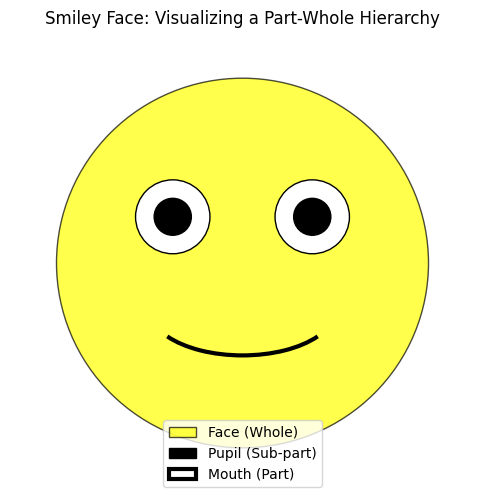

Hierarchy Conceptualization for the Smiley Face:
Level 3: Face (Whole)
  ├── Level 2: Left Eye (Part)
  │     └── Level 1: Pupil (Sub-part)
  ├── Level 2: Right Eye (Part)
  │     └── Level 1: Pupil (Sub-part)
  └── Level 2: Mouth (Part)

In GLOM, each part/whole at a specific level (e.g., "Left Eye" at Level 2) would be represented by an island of identical embedding vectors across the image locations it occupies.


In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc # Changed Rectangle to Arc for a smile
import numpy as np

# Create a smiley face
fig, ax = plt.subplots(figsize=(6, 6))
face = Circle((0.5, 0.5), 0.4, color='yellow', ec='black', alpha=0.7, label='Face (Whole)') # The whole face
left_eye_socket = Circle((0.35, 0.6), 0.08, color='white', ec='black')
left_pupil = Circle((0.35, 0.6), 0.04, color='black', label='Pupil (Sub-part)') # Part: left eye pupil
right_eye_socket = Circle((0.65, 0.6), 0.08, color='white', ec='black')
right_pupil = Circle((0.65, 0.6), 0.04, color='black') # Part: right eye pupil
mouth = Arc((0.5, 0.4), 0.4, 0.2, angle=0, theta1=200, theta2=340, color='black', lw=3, label='Mouth (Part)') # Part: mouth

ax.add_patch(face)
ax.add_patch(left_eye_socket)
ax.add_patch(left_pupil)
ax.add_patch(right_eye_socket)
ax.add_patch(right_pupil)
ax.add_patch(mouth)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.title('Smiley Face: Visualizing a Part-Whole Hierarchy')
plt.legend(loc='lower center')
plt.show()

# Print the hierarchy as a simple tree
print('Hierarchy Conceptualization for the Smiley Face:')
print('Level 3: Face (Whole)')
print('  ├── Level 2: Left Eye (Part)')
print('  │     └── Level 1: Pupil (Sub-part)')
print('  ├── Level 2: Right Eye (Part)')
print('  │     └── Level 1: Pupil (Sub-part)')
print('  └── Level 2: Mouth (Part)')

print('\nIn GLOM, each part/whole at a specific level (e.g., "Left Eye" at Level 2) would be represented by an island of identical embedding vectors across the image locations it occupies.')

## 2. Background Concepts for Understanding GLOM

GLOM isn't built in a vacuum; it synthesizes and extends several important ideas in artificial intelligence and neuroscience. Understanding these foundational concepts will make GLOM's architecture and mechanisms clearer.

### 2.1 Parse Trees in Vision

**What’s a Parse Tree?**
In linguistics, a parse tree shows the grammatical structure of a sentence. In computer vision, a parse tree represents the hierarchical decomposition of an image or object into its constituent parts. It's like a visual 'family tree' where the main object is the ancestor, its major components are its children, and so on, down to the smallest recognizable details. The nodes in this tree represent parts or wholes, and the edges represent their relationships (e.g., 'is part of,' 'is to the left of').

**Why Parse Trees for Vision?**
Representing images as parse trees offers several advantages:
1.  **Compositionality:** It reflects how complex objects are composed of simpler parts.
2.  **Interpretability:** It makes the model's understanding of an image more transparent. We can see what parts it identified and how it combined them.
3.  **Robustness:** If some parts are occluded or distorted, the model might still recognize the object based on the visible parts and their expected relationships.
4.  **Viewpoint Invariance:** By focusing on the intrinsic relationships between parts (e.g., an eye is *above* a mouth *on a face*), rather than their absolute pixel coordinates, parse trees can help achieve viewpoint invariance.

**Example: A Car**
A parse tree for a car might look like this:
- Car (Root - Whole Object)
  - Body (Part of Car)
    - Roof (Sub-part of Body)
    - Doors (Sub-part of Body)
      - Door Handle (Sub-part of Door)
      - Window (Sub-part of Door)
  - Wheels (Part of Car - typically multiple instances)
    - Tire (Sub-part of Wheel)
    - Rim (Sub-part of Wheel)
  - Engine (Part of Car - internal, might be inferred)

**GLOM's Approach to Parse Trees:**
GLOM aims to create parse trees where each node (a part or a whole at a certain level of abstraction) is represented by an 'island' of identical embedding vectors. This means that all image locations (columns in GLOM's architecture) that belong to a specific part (e.g., the left front tire) will share the same vector representation for that part at that level of the hierarchy. The challenge GLOM addresses is how a neural network with a *fixed architecture* can dynamically create these parse trees, which have *different structures for each image*.

**Visualization of a Conceptual Parse Tree**
Let's use `graphviz` to visualize a simple parse tree for an abstract object.

Conceptual Parse Tree Visualization (if graphviz is installed):


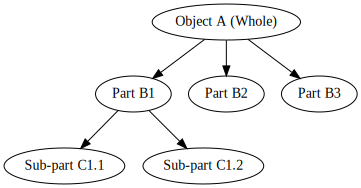

In [2]:
try:
    import graphviz
except ImportError:
    print("graphviz is not installed. Please install it to see this visualization.")
    print("You can typically install it using: pip install graphviz")
    graphviz = None

if graphviz:
    # Create a new directed graph
    dot = graphviz.Digraph(comment='Parse Tree Example')

    # Add nodes (parts and wholes)
    dot.node('A', 'Object A (Whole)')
    dot.node('B', 'Part B1')
    dot.node('C', 'Part B2')
    dot.node('D', 'Sub-part C1.1')
    dot.node('E', 'Sub-part C1.2')
    dot.node('F', 'Part B3')

    # Add edges (relationships)
    dot.edge('A', 'B')
    dot.edge('A', 'C')
    dot.edge('B', 'D')
    dot.edge('B', 'E')
    dot.edge('A', 'F')

    # Display the graph in a Jupyter notebook or render it
    print("Conceptual Parse Tree Visualization (if graphviz is installed):")
    display(dot)
else:
    print("\nConceptual Parse Tree Structure:")
    print("Object A (Whole)")
    print("├── Part B1")
    print("│   ├── Sub-part C1.1")
    print("│   └── Sub-part C1.2")
    print("├── Part B2")
    print("└── Part B3")

### 2.2 Capsule Networks

**What Are They?**
Capsule Networks, introduced by Geoffrey Hinton and his team (e.g., Sabour et al., 2017 [2]), are a type of neural network designed to better model hierarchical relationships and be more robust to viewpoint changes than traditional CNNs. Instead of individual neurons outputting a single scalar activation, capsules are groups of neurons that output a vector. This vector can represent various properties of an entity (like an object or a part), such as its presence, pose (position, orientation, scale), deformation, texture, etc.

**Key Ideas in Capsule Networks:**
1.  **Activity Vectors:** A capsule's output is a vector. The length (magnitude) of this vector typically represents the probability that the entity detected by the capsule is present. The orientation of the vector can encode its instantiation parameters (e.g., pose).
2.  **Dynamic Routing (e.g., Routing-by-Agreement):** Lower-level capsules make predictions (votes) for the pose and presence of higher-level capsules. These predictions are weighted, and an iterative routing algorithm adjusts these weights based on how well the predictions agree. If multiple lower-level capsules (e.g., eye, nose, mouth) make consistent predictions for a higher-level capsule (e.g., face), the connection strengths are increased, and the higher-level capsule becomes active.
3.  **Viewpoint Equivariance/Invariance:** The goal is to achieve viewpoint equivariance at each layer (the capsule's activity vector changes predictably with viewpoint changes) and ultimately viewpoint invariance for object recognition (the final classification is stable across viewpoints).

**How They Work (Simplified):**
Imagine you have capsules that detect eyes and a mouth.
- Each of these low-level capsules (e.g., 'eye capsule') generates a prediction for what a 'face capsule' should look like and where it should be, given the eye it detected. This prediction is a transformation of its own pose.
- The 'face capsule' collects these predictions. If the predictions from the 'eye capsule' and the 'mouth capsule' are similar (they 'agree' on the pose of the face), then the 'face capsule' becomes highly active.
- This routing process is dynamic and happens for every input image.

**Limitations that GLOM Addresses:**
The original capsule models (e.g., [Sabour et al., 2017; Hinton et al., 2018; Kosiorek et al., 2019]) made the assumption that a group of neurons (a capsule) would be permanently dedicated to a part of a particular type occurring in a particular region of the image. [1] This pre-allocation can be limiting. GLOM proposes a different way: using 'islands of identical vectors' which avoids pre-allocating neurons to specific parts and allows for more dynamic representation. Furthermore, early capsule models struggled to scale to larger datasets and more complex scenes. [Barham and Isard, 2019, as cited in 1]. A fundamental weakness identified by Hinton is that capsules use a mixture to model the set of possible parts, forcing hard decisions (e.g., is a car headlight and an eye the same part type?). [1]

**GLOM's Connection to Capsules:**
GLOM inherits the idea of representing entities with rich vectors (embeddings) and the importance of part-whole relationships. However, it moves away from pre-defined capsules and dynamic routing between them. Instead, GLOM uses a fixed architecture with shared weights and forms 'islands' of identical embeddings to represent nodes in a parse tree. The 'embedding vector' in GLOM can be seen as the 'activity vector of a capsule'. [1] GLOM also explores 'universal capsules' – identical capsules that can model any type of part, where part identity is represented in the activity vector itself rather than by which capsule is active. [1]

**Visualization: Conceptual Capsules Voting**
Imagine arrows (votes) from 'eye' and 'mouth' part-capsules. If these arrows align or point to a consistent 'face' pose, the 'face' capsule activates.

Votes agreed! Face capsule would be activated.


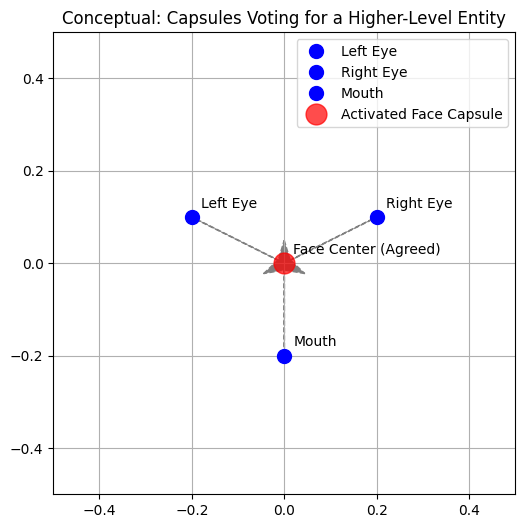

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6,6))

# Define parts and their conceptual votes for a 'face' center
parts = {
    'Left Eye': {'pos': np.array([-0.2, 0.1]), 'vote_target_offset': np.array([0.2, -0.1])},
    'Right Eye': {'pos': np.array([0.2, 0.1]), 'vote_target_offset': np.array([-0.2, -0.1])},
    'Mouth': {'pos': np.array([0.0, -0.2]), 'vote_target_offset': np.array([0.0, 0.2])}
}

face_center_predictions = []

for name, data in parts.items():
    part_pos = data['pos']
    vote_offset = data['vote_target_offset']
    predicted_face_center = part_pos + vote_offset # Simplified vote
    face_center_predictions.append(predicted_face_center)

    # Plot part
    ax.plot(part_pos[0], part_pos[1], 'bo', markersize=10, label=name if name not in [p.get_label() for p in ax.patches+ax.lines] else "")
    ax.text(part_pos[0]+0.02, part_pos[1]+0.02, name)

    # Plot vote vector
    ax.arrow(part_pos[0], part_pos[1], vote_offset[0], vote_offset[1],
             head_width=0.03, head_length=0.05, fc='gray', ec='gray', linestyle='--')

# Calculate the average predicted face center (if they agree)
face_center_predictions = np.array(face_center_predictions)
avg_prediction = np.mean(face_center_predictions, axis=0)

# Check for agreement (simplified: if variance is low)
if np.var(face_center_predictions) < 0.01: # Arbitrary threshold for agreement
    ax.plot(avg_prediction[0], avg_prediction[1], 'ro', markersize=15, alpha=0.7, label='Activated Face Capsule')
    ax.text(avg_prediction[0]+0.02, avg_prediction[1]+0.02, 'Face Center (Agreed)')
    print("Votes agreed! Face capsule would be activated.")
else:
    print("Votes did not agree sufficiently.")
    # Plot individual predictions if they don't agree
    for i, p_center in enumerate(face_center_predictions):
        ax.plot(p_center[0], p_center[1], 'rx', markersize=8, label=f'Vote {i+1}' if i==0 else None)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_title('Conceptual: Capsules Voting for a Higher-Level Entity')
ax.legend()
ax.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 2.3 Transformers and Attention

**What Are Transformers?**
Transformers are a type of neural network architecture initially introduced for natural language processing (NLP) tasks (Vaswani et al., 2017, "Attention Is All You Need"). They have since been successfully adapted for computer vision (e.g., Vision Transformer or ViT by Dosovitskiy et al., 2020).

**Core Mechanism: Self-Attention**
The key innovation in transformers is the self-attention mechanism. For any given element in a sequence (like a word in a sentence, or an image patch in a set of patches), self-attention allows the model to weigh the importance of all other elements in the sequence relative to the current element. It dynamically decides what to "pay attention to."

**How Self-Attention Works (Simplified):**
For each input element (e.g., an embedding of an image patch):
1.  **Queries, Keys, Values:** Three vectors are created: a Query (Q), a Key (K), and a Value (V).
    *   **Query:** Represents the current element asking for information.
    *   **Key:** Represents an element that might have relevant information.
    *   **Value:** Represents the information itself from that element.
2.  **Scores:** The Query of the current element is compared (often via dot product) with the Keys of all other elements (including itself). This produces a score indicating how much attention the current element should pay to each other element.
3.  **Weights:** These scores are typically scaled and passed through a softmax function to convert them into attention weights (probabilities that sum to 1).
4.  **Weighted Sum:** The Value vectors of all elements are multiplied by their respective attention weights and summed up. This results in a new representation for the current element that incorporates contextual information from other relevant elements.

**Transformers in Vision (e.g., ViT):**
1.  **Patching:** An image is divided into a grid of fixed-size patches (e.g., 16x16 pixels).
2.  **Embedding:** Each patch is flattened and linearly projected into an embedding vector. Positional embeddings are added to retain spatial information.
3.  **Transformer Encoder:** This sequence of patch embeddings is fed into a standard Transformer encoder, which consists of multiple layers of self-attention and feed-forward networks.

**GLOM's Connection to Transformers:**
GLOM incorporates transformer-like ideas, especially attention, but with simplifications:
1.  **Inter-Column Interactions:** GLOM uses an attention mechanism for interactions between embeddings at the same level in different columns (image locations). This helps to form 'islands of identical embeddings.'
2.  **Simplified Attention:** In GLOM's inter-column attention, the Query, Key, and Value vectors are all identical to the embedding vector itself. The interaction is to make each embedding vector regress towards other similar vectors at nearby locations. This creates 'echo chambers' where embeddings attend mainly to like-minded embeddings. [1]
3.  **Levels as Heads (Conceptual):** The multiple levels of representation within each column in GLOM can be loosely compared to the multiple attention heads in a transformer, where each head can focus on different aspects or relationships. However, in GLOM, these levels are explicitly for the part-whole hierarchy.
4.  **Recurrence:** GLOM can be viewed as a recurrent net where time slices are converted into layers. If the GLOM architecture (Fig. 1 in the paper) is rearranged by viewing vertical time-slices as layers (Fig. 4 in the paper), it resembles a transformer but with shared weights across layers (due to recurrence) and the simplified attention. [1]

**Visualization: Attention Heatmap**
Imagine an image of a cat. If we are focusing on a patch representing the cat's ear, the attention mechanism would assign higher weights to other patches also belonging to the cat (especially other ear parts or head parts) and lower weights to background patches.

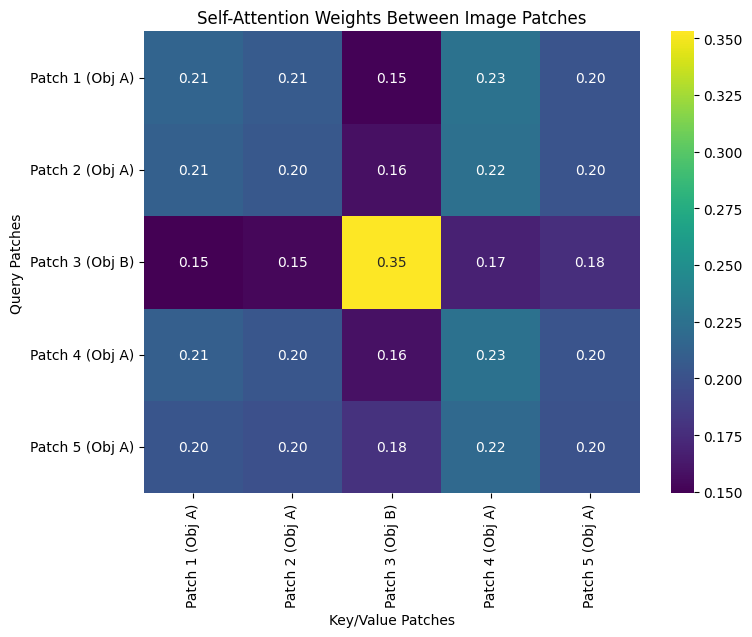

Example: 'Patch 1 (Obj A)' (first row) pays high attention to other 'Obj A' patches (Patch 2, 4, 5) and low attention to 'Patch 3 (Obj B)'.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate embeddings for 5 image patches
# Patch 1, 2: Part of 'Object A' (e.g., cat's ear)
# Patch 3: Part of 'Object B' (e.g., tree)
# Patch 4, 5: Part of 'Object A' (e.g., cat's eye)
embeddings = np.array([
    [0.1, 0.8, 0.1],  # Patch 1 (Object A)
    [0.15, 0.75, 0.1], # Patch 2 (Object A)
    [0.7, 0.2, 0.8],  # Patch 3 (Object B)
    [0.2, 0.85, 0.15], # Patch 4 (Object A)
    [0.25, 0.7, 0.2]  # Patch 5 (Object A)
])
patch_labels = ['Patch 1 (Obj A)', 'Patch 2 (Obj A)', 'Patch 3 (Obj B)', 'Patch 4 (Obj A)', 'Patch 5 (Obj A)']

# Simplified self-attention: Q, K, V are the embeddings themselves
# Calculate scores (dot product similarity)
scores = np.dot(embeddings, embeddings.T)

# Apply softmax to get attention weights
attention_weights = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)

# Visualize the attention matrix for Patch 1
plt.figure(figsize=(8, 6))
sns.heatmap(attention_weights, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=patch_labels, yticklabels=patch_labels)
plt.title('Self-Attention Weights Between Image Patches')
plt.xlabel('Key/Value Patches')
plt.ylabel('Query Patches')
plt.show()

print("Example: 'Patch 1 (Obj A)' (first row) pays high attention to other 'Obj A' patches (Patch 2, 4, 5) and low attention to 'Patch 3 (Obj B)'.")

### 2.4 Neural Fields (Implicit Neural Representations)

**What Are They?**
Neural Fields, also known as Implicit Neural Representations (INRs) or Coordinate-based Neural Networks, are a way of representing complex signals (like images, shapes, or scenes) using a neural network. Instead of discretizing the signal (e.g., into pixels or voxels), a neural field parameterizes the signal as a continuous function. This function, typically a multilayer perceptron (MLP), maps input coordinates (e.g., `(x, y)` for an image, `(x, y, z)` for a 3D shape) to corresponding signal values (e.g., RGB color, occupancy, signed distance).
Popular examples include NeRF (Mildenhall et al., 2020) for novel view synthesis and SIREN (Sitzmann et al., 2020) for representing signals with periodic activation functions.

**Key Characteristics:**
1.  **Continuous Representation:** Signals are defined for any point in the coordinate space, allowing for theoretically infinite resolution.
2.  **Memory Efficiency:** The representation is stored in the weights of the neural network, which can be much smaller than storing a high-resolution discretized signal.
3.  **Differentiability:** Since they are neural networks, they are differentiable, allowing them to be trained with gradient descent, often to reconstruct a target signal.

**Example: Representing an Image with a Neural Field**
An MLP could be trained to take `(x, y)` coordinates (normalized to, say, `[-1, 1]`) as input and output the `(R, G, B)` color of the pixel at that location. The entire image is then encoded in the weights of this MLP.

**GLOM's Connection to Neural Fields:**
GLOM utilizes the concept of neural fields in its architecture, particularly for the top-down pathways and for interpreting the visual input:
1.  **Hierarchical Neural Fields:** Hinton suggests that if images are composed of familiar objects and objects are composed of familiar parts, it is much more efficient to use a *hierarchy of neural fields*. [1]
    *   **Scene-level to Object-level:** A scene-level top-down neural network could convert a scene vector plus an image location into the appropriate object vector for that location. This object vector would include information like the 3D pose of the object.
    *   **Object-level to Part-level:** Similarly, an object-level top-down neural network could convert an object vector plus a location into the part vector appropriate for that location. [1]
    The crucial idea is that all locations belonging to the same object are given exactly the same object-level vector. The neural field then determines which part is present at a specific location *within* that object's frame.
2.  **Visual Input Processing:** The raw visual input at the lowest level of GLOM could be processed by a learned neural field. The problem is framed as: what lowest-level embedding for a location would be able to reconstruct the pixel intensities using a neural field shared by all locations? This embedding can be refined by backpropagating the reconstruction error through the neural field. [1]
3.  **Coordinate Representation:** Work on neural fields (e.g., Sitzmann et al., 2020 [4, 9, 18]; Mildenhall et al., 2020 [9, 18]) has shown that using more sophisticated input encodings for coordinates (e.g., positional encodings with sine and cosine waves of various frequencies, as used in Transformers and NeRF) works much better than raw scalar coordinates. GLOM assumes these advanced techniques for representing location when neural fields are involved. [1]

**Simplified Code Example: A Neural Field for a 1D Signal**
Let's create a very simple MLP to learn a 1D sine wave. This illustrates how a network can map coordinates to signal values.

Epoch [200/1000], Loss: 0.0014
Epoch [400/1000], Loss: 0.0001
Epoch [600/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


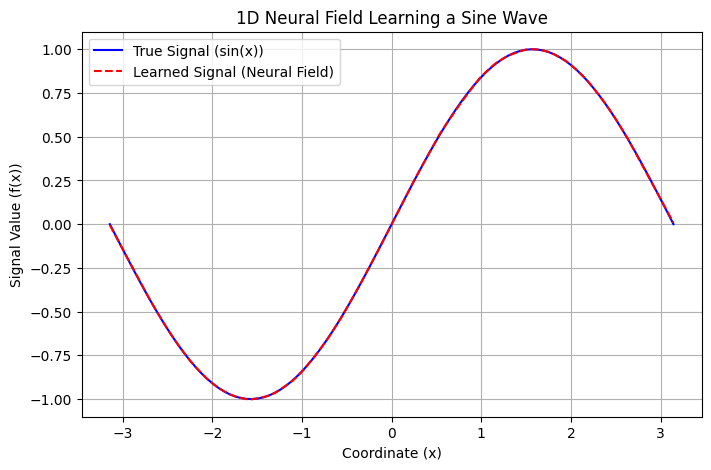

This demonstrates a neural network learning to map coordinates to signal values. GLOM would use more complex neural fields for image properties.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define a simple MLP
class NeuralField1D(nn.Module):
    def __init__(self):
        super(NeuralField1D, self).__init__()
        self.layer1 = nn.Linear(1, 64) # Input: 1D coordinate
        self.activation1 = nn.ReLU() # Using ReLU for simplicity, SIREN uses sin
        self.layer2 = nn.Linear(64, 64)
        self.activation2 = nn.ReLU()
        self.output_layer = nn.Linear(64, 1) # Output: 1D signal value

    def forward(self, x):
        x = self.activation1(self.layer1(x))
        x = self.activation2(self.layer2(x))
        x = self.output_layer(x)
        return x

# Generate training data (a sine wave)
coordinates = torch.linspace(-np.pi, np.pi, 100).unsqueeze(1) # unsqueeze to make it [100, 1]
signal_values = torch.sin(coordinates)

# Initialize model, loss, and optimizer
model = NeuralField1D()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(coordinates)
    loss = criterion(predictions, signal_values)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Test the model
model.eval()
with torch.no_grad():
    learned_signal = model(coordinates)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(coordinates.numpy(), signal_values.numpy(), label='True Signal (sin(x))', color='blue')
plt.plot(coordinates.numpy(), learned_signal.numpy(), label='Learned Signal (Neural Field)', color='red', linestyle='--')
plt.title('1D Neural Field Learning a Sine Wave')
plt.xlabel('Coordinate (x)')
plt.ylabel('Signal Value (f(x))')
plt.legend()
plt.grid(True)
plt.show()

print("This demonstrates a neural network learning to map coordinates to signal values. GLOM would use more complex neural fields for image properties.")

### 2.5 Contrastive Representation Learning

**What Is It?**
Contrastive Learning is a powerful self-supervised learning technique. The core idea is to learn representations (embeddings) by contrasting positive pairs against negative pairs.
-   **Positive Pairs:** These are pairs of data points that should have similar representations. For example, two different augmented views (e.g., crops, color jitters) of the same image, or two patches from the same object.
-   **Negative Pairs:** These are pairs of data points that should have dissimilar representations. For example, augmented views from different images, or a patch from an object and a patch from the background.

The learning objective is to pull the representations of positive pairs closer together in the embedding space while pushing the representations of negative pairs further apart.

**How It Works (Conceptual Loss Function):**
A common approach involves a loss function like Noise Contrastive Estimator (NCE) or InfoNCE. For a given anchor sample `x`:
1.  Create a positive sample `x+` (e.g., an augmentation of `x`).
2.  Create one or more negative samples `x-` (e.g., other samples from the batch).
3.  Embed all samples: `h = f(x)`, `h+ = f(x+)`, `h- = f(x-)`.
4.  The loss encourages the similarity (e.g., cosine similarity or dot product) between `h` and `h+` to be high, and the similarity between `h` and `h-` to be low.

**Example in Vision:**
If you take an image of a cat, create two different crops of it. The learned embeddings for these two cat crops (positive pair) should be close. An embedding of a crop from a dog image (negative pair relative to the cat crops) should be far away.

**GLOM's Connection to Contrastive Learning:**
Contrastive learning is a key component for training GLOM, especially for encouraging the formation of 'islands of near identity.'
1.  **Preventing Collapse:** When trying to make embeddings of nearby locations similar (to form islands), there's a risk of 'collapse,' where all embedding vectors become very small or identical, making them useless. Contrastive learning, by using negative examples, maintains separation between representations that *should not* agree, thus preventing this collapse. [1]
2.  **Learning at Different Levels:** Contrastive loss can be applied at different levels of the GLOM hierarchy. The paper states: "it would be better to use a contrastive loss function that encourages very similar representations for two locations at level L *only if they belong to the same entity at level L*. If they belong to different level L entities their level L embeddings should be significantly different." [1]
3.  **Learning from Image Crops:** The paper discusses successful applications of contrastive learning to image crops (e.g., [Chen et al., 2020a; Bachman et al., 2019; He et al., 2020]). However, it also points out that simply making representations of two different crops from the same image agree at the *object level* might not be sensible if the crops contain different objects (e.g., crop 1 has objects A & B, crop 2 has B & C). It makes more sense at the *scene level*. [1]
4.  **Video Sequences:** Recent work (e.g., [Jabri et al., 2020]) has used the similarity of patches along an object's trajectory in video to guide contrastive learning, which is relevant to GLOM's potential extension to video. [1]
5.  **Potential for No Negative Examples?:** The paper speculates that if an embedding at one location is free to choose which embeddings at other locations it should resemble, the goal of forming islands might be achievable almost perfectly. This, combined with a deep denoising autoencoder objective, might reduce or even eliminate the need for explicit negative examples, thereby avoiding collapse without them. [1]

**Visualization: Embedding Space**
Imagine a 2D space where positive pairs (blue dots) are close and negative pairs (blue vs. red dot) are far.

Distance to positive: 0.01
Distance to negative: 1.81
Contrastive Loss: 0.01


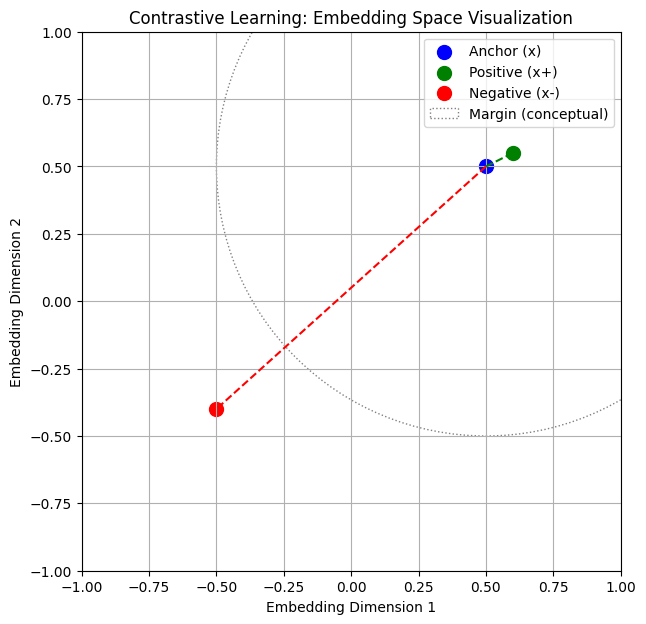

Contrastive learning aims to minimize the distance between anchor and positive (green line) while maximizing the distance (beyond a margin) between anchor and negative (red line).


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Simple contrastive loss function (conceptual)
def contrastive_loss_example(embedding_anchor, embedding_positive, embedding_negative, margin=1.0):
    # Distances in embedding space
    dist_positive = np.linalg.norm(embedding_anchor - embedding_positive)**2
    dist_negative = np.linalg.norm(embedding_anchor - embedding_negative)**2

    # Loss: pull positives close, push negatives away beyond a margin
    loss = dist_positive + np.maximum(0, margin - dist_negative)
    return loss, dist_positive, dist_negative

# Sample 2D embeddings
emb_anchor = np.array([0.5, 0.5])    # e.g., embedding of a cat image patch
emb_positive = np.array([0.6, 0.55])  # e.g., embedding of an augmented version of the same cat patch
emb_negative = np.array([-0.5, -0.4]) # e.g., embedding of a dog image patch

loss_val, d_pos, d_neg = contrastive_loss_example(emb_anchor, emb_positive, emb_negative)
print(f'Distance to positive: {d_pos:.2f}')
print(f'Distance to negative: {d_neg:.2f}')
print(f'Contrastive Loss: {loss_val:.2f}')

# Plot the embeddings
plt.figure(figsize=(7, 7))
plt.scatter(emb_anchor[0], emb_anchor[1], c='blue', s=100, label='Anchor (x)', marker='o')
plt.scatter(emb_positive[0], emb_positive[1], c='green', s=100, label='Positive (x+)', marker='o')
plt.scatter(emb_negative[0], emb_negative[1], c='red', s=100, label='Negative (x-)', marker='o')

# Draw lines to show distances
plt.plot([emb_anchor[0], emb_positive[0]], [emb_anchor[1], emb_positive[1]], 'g--')
plt.plot([emb_anchor[0], emb_negative[0]], [emb_anchor[1], emb_negative[1]], 'r--')

# Draw margin around anchor for negative example
circle = plt.Circle((emb_anchor[0], emb_anchor[1]), np.sqrt(1.0), color='gray', fill=False, linestyle=':', label='Margin (conceptual)')
ax = plt.gca()
ax.add_artist(circle)

plt.title('Contrastive Learning: Embedding Space Visualization')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print('Contrastive learning aims to minimize the distance between anchor and positive (green line) while maximizing the distance (beyond a margin) between anchor and negative (red line).')


### 2.6 Denoising Autoencoders

**What Are Autoencoders?**
An autoencoder is a type of neural network used for unsupervised learning, primarily for learning efficient data codings (compressions) in an unsupervised manner. It consists of two main parts:
1.  **Encoder:** This part takes an input `x` and maps it to a lower-dimensional latent representation (or code) `z`. `z = encoder(x)`.
2.  **Decoder:** This part takes the latent representation `z` and tries to reconstruct the original input `x`. `x_reconstructed = decoder(z)`.

The network is trained by minimizing the reconstruction error, which is the difference between the original input `x` and the reconstructed output `x_reconstructed` (e.g., using Mean Squared Error).

**What Are Denoising Autoencoders (DAEs)?**
A Denoising Autoencoder is a variation of the autoencoder that is trained to reconstruct a *clean* version of an input that has been corrupted with noise.
1.  **Corrupted Input:** Start with an original input `x`.
2.  **Add Noise:** Create a corrupted version `x_corrupted` by adding some form of noise (e.g., Gaussian noise, masking out parts of the input).
3.  **Encoding & Decoding:** The encoder takes `x_corrupted` as input to produce the latent code `z`. The decoder then tries to reconstruct the *original, clean* input `x` from `z`.
    `z = encoder(x_corrupted)`
    `x_reconstructed = decoder(z)`
4.  **Training Objective:** The network is trained to minimize the difference between `x_reconstructed` and the *original, clean* `x`.

**Why Denoising?**
By forcing the autoencoder to denoise the input, it learns more robust features. It cannot simply learn an identity mapping (copying the input to the output) or memorize the training data. Instead, it must capture the underlying manifold or structure of the data to effectively fill in the missing information or remove the noise.

**Example:**
If you train a DAE on images of handwritten digits, you might feed it images where some pixels are randomly turned off. The DAE would learn to fill in these missing pixels and output a complete, clean digit. In doing so, it learns the essential features that define each digit.

**GLOM's Connection to Denoising Autoencoders:**
GLOM's training objective and architecture incorporate ideas from DAEs:
1.  **Reconstruction Objective:** The paper suggests that GLOM can be trained end-to-end to reconstruct images at the final time-step from input images which have missing regions. [1] This is directly analogous to the denoising objective, where missing regions is the form of corruption.
2.  **Learning Robust Representations:** This reconstruction task, especially if the missing regions are sufficiently large, should ensure that information about the input is preserved during the forward pass and that identifying familiar objects will be helpful for filling in the missing regions. [1] This helps the system learn meaningful and robust representations.
3.  **Combination with Contrastive Learning:** The deep denoising autoencoder objective function, when combined with techniques like contrastive learning (and other recent tricks like [Grill et al., 2020; Chen and He, 2020]), is hypothesized to potentially eliminate the need for negative examples in contrastive learning to prevent representational collapse. [1]
4.  **Iterative Refinement:** GLOM's iterative process of updating embeddings across levels and time steps can be seen as a form of iterative denoising or refinement of the representation of the image.

**Simplified Code Example: Denoising a 1D Signal**
Let's corrupt a simple 1D signal (e.g., a sine wave with some points masked out) and train an autoencoder to reconstruct the original.

Epoch [300/1500], DAE Loss: 0.0011
Epoch [600/1500], DAE Loss: 0.0001
Epoch [900/1500], DAE Loss: 0.0000
Epoch [1200/1500], DAE Loss: 0.0000
Epoch [1500/1500], DAE Loss: 0.0000


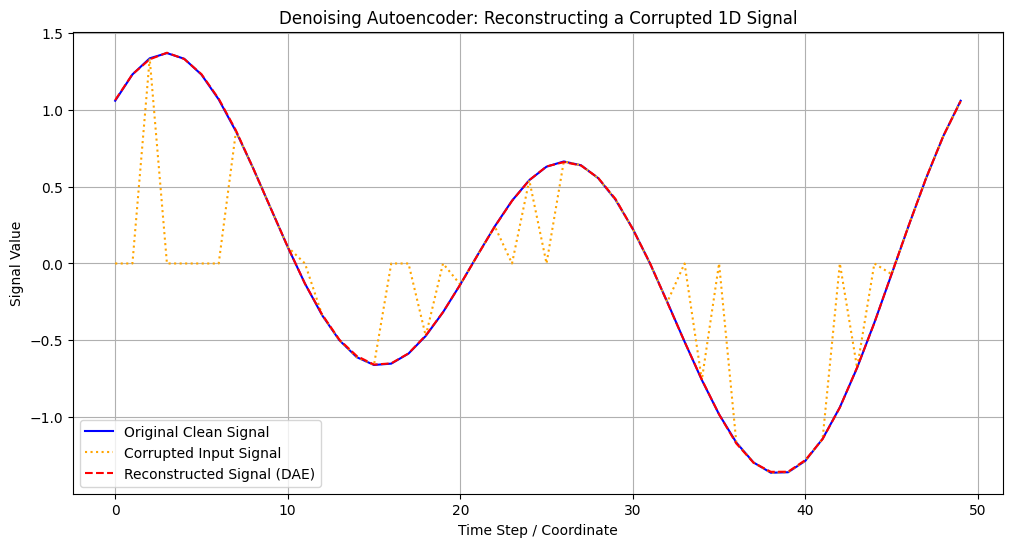

The DAE learns to fill in the masked (zeroed) parts of the signal by capturing its underlying structure.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define a simple Autoencoder for 1D signal
class Autoencoder1D(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder1D, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Generate training data (a batch of sine waves)
signal_length = 50
num_samples = 200
clean_signals = torch.zeros(num_samples, signal_length)
for i in range(num_samples):
    start_phase = np.random.rand() * np.pi
    x_coords = torch.linspace(start_phase, start_phase + 4*np.pi, signal_length)
    clean_signals[i] = torch.sin(x_coords) + 0.5 * torch.sin(0.5 * x_coords) # More complex signal

# Create corrupted signals (e.g., masking some parts)
corrupted_signals = clean_signals.clone()
mask_percentage = 0.3
for i in range(num_samples):
    mask = torch.rand(signal_length) < mask_percentage
    corrupted_signals[i][mask] = 0 # Set masked parts to zero

# Initialize model, loss, and optimizer
model_dae = Autoencoder1D(input_dim=signal_length, encoding_dim=10) # Small encoding dim
criterion_dae = nn.MSELoss()
optimizer_dae = optim.Adam(model_dae.parameters(), lr=0.001)

# Training loop
epochs_dae = 1500
for epoch in range(epochs_dae):
    optimizer_dae.zero_grad()
    reconstructions = model_dae(corrupted_signals) # Input corrupted, target clean
    loss_dae = criterion_dae(reconstructions, clean_signals)
    loss_dae.backward()
    optimizer_dae.step()
    if (epoch + 1) % 300 == 0:
        print(f'Epoch [{epoch+1}/{epochs_dae}], DAE Loss: {loss_dae.item():.4f}')

# Test the DAE model
model_dae.eval()
with torch.no_grad():
    sample_idx = np.random.randint(0, num_samples)
    test_corrupted = corrupted_signals[sample_idx:sample_idx+1]
    test_clean = clean_signals[sample_idx:sample_idx+1]
    reconstructed_signal = model_dae(test_corrupted)

# Plot the results for one sample
plt.figure(figsize=(12, 6))
plt.plot(test_clean.squeeze().numpy(), label='Original Clean Signal', color='blue')
plt.plot(test_corrupted.squeeze().numpy(), label='Corrupted Input Signal', color='orange', linestyle=':')
plt.plot(reconstructed_signal.squeeze().numpy(), label='Reconstructed Signal (DAE)', color='red', linestyle='--')
plt.title('Denoising Autoencoder: Reconstructing a Corrupted 1D Signal')
plt.xlabel('Time Step / Coordinate')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()

print("The DAE learns to fill in the masked (zeroed) parts of the signal by capturing its underlying structure.")

## 3. GLOM Architecture Explained

GLOM is conceptualized as an architecture designed to process images (initially static, but with extensions to video) by forming hierarchical representations. The core components and their interactions are key to understanding its potential.

**Core Architectural Ideas:**

1.  **Columns with Multiple Levels:**
    *   Imagine the input image (or its feature map from a preliminary CNN) is divided into a spatial grid. Each element or patch in this grid corresponds to a **column** in GLOM. [1]
    *   Each column is not monolithic; it contains multiple **levels** of representation. These levels correspond to the levels in a part-whole hierarchy. For example, a lower level in a column might represent fine-grained details like edges or simple textures within that image patch, while a higher level in the same column might represent a part of an object, or even a whole object if the patch is large enough or the object is small. [1]
    *   At each level `L` within a column `x`, there is an **embedding vector**. This vector is the representation of what's happening at that specific image location `x` at that specific hierarchical level `L`. [1]

2.  **Identical Weights Across Columns:**
    *   A crucial aspect of GLOM is that the neural network machinery (the weights) used within each column is **identical** across all columns. This is akin to how convolutional filters are shared across all spatial locations in a CNN. This weight sharing promotes learning generalizable features and transformations. [1]

3.  **Stacks of Spatially Local Autoencoders:**
    *   Each column can be thought of as containing a stack of spatially local autoencoders. Each autoencoder is responsible for transforming the embedding at one level into the embedding at an adjacent level. [1]
    *   This involves a **multilayer bottom-up encoder** (passing information to higher, more abstract levels) and a **multilayer top-down decoder** (passing information to lower, more detailed levels). [1]
    *   For example, to get the embedding at level `L` from level `L-1` (bottom-up), an encoder is used. To get a prediction for level `L-1` from level `L` (top-down), a decoder is used.

4.  **Islands of Identical Embeddings:**
    *   This is the central idea for representing parse tree nodes. For a static image, over several processing time steps (iterations), the embeddings at a particular level `L` are expected to **settle down** to form **islands of nearly identical vectors**. [1]
    *   All columns (locations) that perceive the same part or object at level `L` will converge to having the *same* embedding vector for that level `L`.
    *   For instance, if an image contains a face, all columns corresponding to the pixels of the nose might converge to the same embedding vector at the "nose part" level. Similarly, all columns corresponding to the entire face might converge to another identical embedding vector at the "face object" level. These islands would be larger at higher levels of the hierarchy (e.g., a 'face' island is larger than a 'nose' island). [1]
    *   This avoids the need to dynamically allocate groups of neurons to represent nodes; instead, GLOM allocates an appropriate *activity vector* (the shared embedding) to represent the node, and this same activity vector is used for all locations belonging to that node. [3]

5.  **Iterative Processing (Settling Over Time):**
    *   GLOM processes a static image over multiple discrete **time steps** (iterations). This iterative process allows the embeddings to be updated and refined based on information from different sources (bottom-up, top-down, and lateral/inter-column). [3]
    *   Even though the paper primarily concerns a single static image, GLOM is easiest to understand as a pipeline for processing a sequence of frames. A static image is treated as a sequence of identical frames. [2]

**Visualizing GLOM's Columnar Structure (Conceptual)**

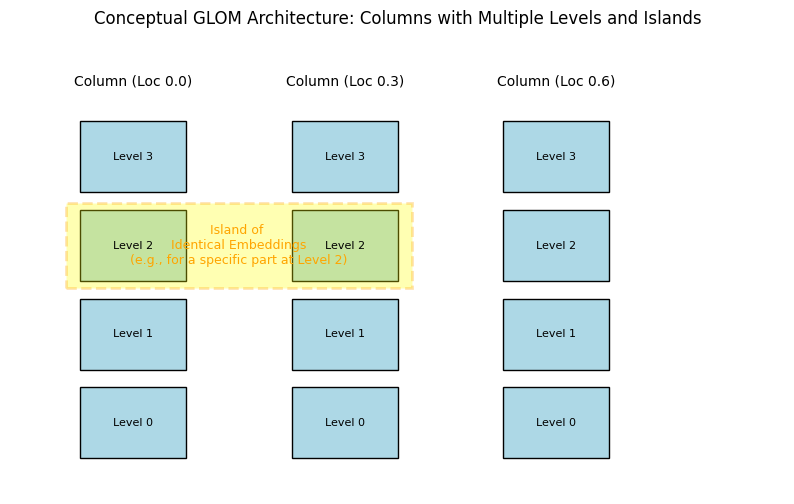

Each column processes a spatial location and has 4 levels of representation.
An 'island' (yellow area) represents multiple columns sharing the same embedding for a particular part/object at a specific level.


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def draw_glom_column(ax, x_offset, num_levels=4, highlight_level=None):
    level_height = 0.2
    level_width = 0.15
    level_spacing = 0.05

    ax.text(x_offset + level_width/2, num_levels * (level_height + level_spacing) + 0.05,
            f'Column (Loc {x_offset:.1f})', ha='center')

    for i in range(num_levels):
        y_pos = i * (level_height + level_spacing)
        color = 'lightblue'
        if highlight_level and i == highlight_level:
            color = 'lightcoral'

        rect = plt.Rectangle((x_offset, y_pos), level_width, level_height,
                             facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        ax.text(x_offset + level_width/2, y_pos + level_height/2, f'Level {i}',
                ha='center', va='center', fontsize=8)
    return (x_offset, y_pos + level_height) # Return top of the column for arrows

fig, ax = plt.subplots(figsize=(10, 6))

num_columns = 3
num_levels = 4
column_spacing = 0.3

col_tops = []
for i in range(num_columns):
    # Highlight different levels in different columns for illustration
    # hl = i % num_levels
    top_coord = draw_glom_column(ax, i * column_spacing, num_levels)
    col_tops.append(top_coord)

# Illustrate an "island" of similar embeddings at Level 2 across two columns
highlight_y_level2 = 2 * (0.2 + 0.05) + 0.2/2 # y-center of level 2
rect_island = plt.Rectangle((0*column_spacing - 0.02, highlight_y_level2 - 0.12),
                            1*column_spacing + 0.15 + 0.04, 0.24,
                            facecolor='yellow', alpha=0.3, edgecolor='orange', linestyle='--', linewidth=2)
ax.add_patch(rect_island)
ax.text(0.5*column_spacing + 0.075, highlight_y_level2, 'Island of \nIdentical Embeddings\n(e.g., for a specific part at Level 2)',
        ha='center', va='center', fontsize=9, color='orange')

ax.set_xlim(-0.1, num_columns * column_spacing + 0.1)
ax.set_ylim(-0.1, num_levels * (0.2 + 0.05) + 0.2)
ax.axis('off')
ax.set_title('Conceptual GLOM Architecture: Columns with Multiple Levels and Islands')
plt.show()

print(f"Each column processes a spatial location and has {num_levels} levels of representation.")
print("An 'island' (yellow area) represents multiple columns sharing the same embedding for a particular part/object at a specific level.")

**How Embeddings are Updated at Each Time Step**
At each discrete time step `t`, and in each column separately, the embedding at a specific level `L` is updated. This update is a **weighted average of four contributions** from the previous time step `t-1`: [3]

1.  **Bottom-Up Prediction:** The prediction produced by the bottom-up neural net acting on the embedding at the level *below* (`L-1`) at the previous time step (`t-1`). This brings in information from finer details.
    *   *Symbolically*: `Pred_BU(Embedding_L-1_t-1)`

2.  **Top-Down Prediction:** The prediction produced by the top-down neural net acting on the embedding at the level *above* (`L+1`) at the previous time step (`t-1`). This brings in contextual information from more abstract representations.
    *   *Symbolically*: `Pred_TD(Embedding_L+1_t-1)`

3.  **Previous State of the Embedding:** The embedding vector itself from the previous time step (`t-1`) at the same level `L`. This provides temporal consistency and allows for gradual refinement.
    *   *Symbolically*: `Embedding_L_t-1`

4.  **Attention-Weighted Average from Nearby Columns:** The attention-weighted average of the embeddings at the *same level* `L` in *nearby columns* at the previous time step (`t-1`). This is the mechanism for lateral communication and helps form the 'islands of identical vectors.'
    *   *Symbolically*: `AttnAvg(Embeddings_L_nearby_t-1)`

The whole system (all these bottom-up/top-down nets) can be trained end-to-end. The objective function would include reconstructing images from input images with missing regions, plus two regularizers that encourage the formation of these islands of near identical vectors at each level. These regularizers are simply the agreement between the new embedding at a level and the bottom-up and top-down predictions. [3]

**Figure 1 from the Paper: Interactions within a Single Column**
Figure 1 in Hinton's paper illustrates these interactions for a *single column* across three adjacent levels (L-1, L, L+1) and three time frames (or iterations).
-   **Blue Arrows (Bottom-Up):** Represent interactions from a lower level to a higher level (e.g., L-1 at frame 1 influencing L at frame 2). These are implemented by a neural network (bottom-up encoder).
-   **Red Arrows (Top-Down):** Represent interactions from a higher level to a lower level (e.g., L+1 at frame 1 influencing L at frame 2). These are implemented by a different neural network (top-down decoder). These networks are shared across columns and time-steps but can differ between pairs of levels.
-   **Green Arrows (Temporal Smoothing/Dynamics):** Represent the influence of the same level from the previous time frame on the current time frame (e.g., L at frame 1 influencing L at frame 2). For a static image, these could be simple scaled residual connections. For video, they could be neural networks learning temporal dynamics.
-   **Interactions between columns (Not shown in Fig 1 detail, but mentioned in caption):** Implemented by non-adaptive, attention-weighted, local smoother for embeddings at the same level in different columns. This is what creates the 'islands'.

**Figure 2 from the Paper: Embeddings at a Particular Time**
Figure 2 shows a snapshot of embeddings at a *particular time* across six nearby columns.
-   Each column displays its embedding vector, which is divided into sections for each level in the part-whole hierarchy (e.g., lowest level, sub-part level, part level, object level, scene level).
-   The high-dimensional embedding vector for a level is illustrated as a 2D vector (an arrow) for simplicity.
-   The figure shows how, at a given time, 'islands of identical vectors' are forming. For example, at the 'part level embeddings', several columns might share the same upward-pointing red arrow, indicating they all represent the same part and their embeddings for that part have aligned. At the 'object level embeddings', a larger group of columns might share the same downward-pointing black arrow.
-   These islands of identity represent a parse tree. They are more powerful than traditional phrase structure grammars because they can represent disconnected objects as well. [5]

**Simulating Island Formation (Conceptual Code)**
This code simulates the core idea of embeddings in a grid 'settling' towards their neighbors if they are similar, leading to 'islands'.

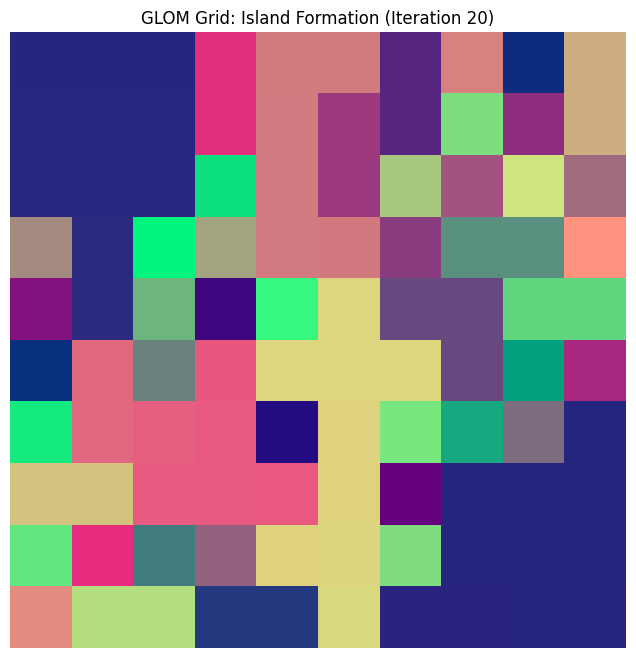

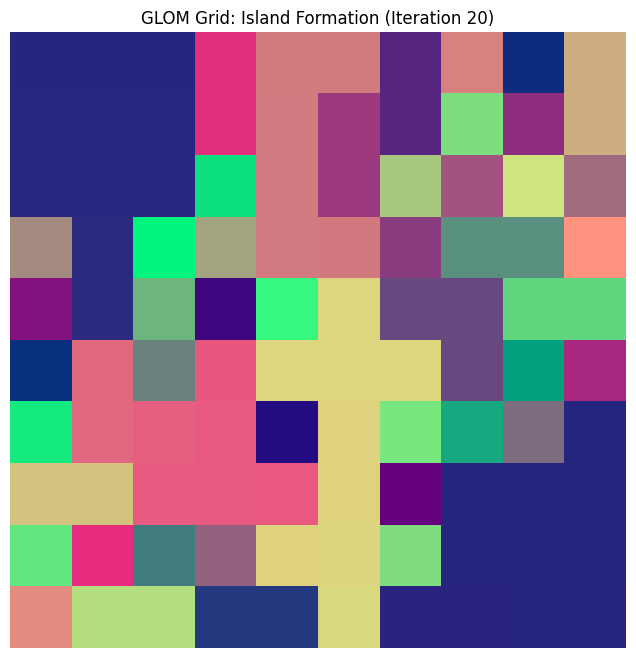


Colors represent the 2D embedding vectors. Similar colors clustering together indicates island formation.
The plus-sign shape and corner regions should become more uniformly colored, indicating distinct islands.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Set up a 5x5 grid with random 2D embeddings (for easy visualization)
grid_size = 10
embeddings = np.random.rand(grid_size, grid_size, 2) * 2 - 1 # Values between -1 and 1

# Predefine a target shape (e.g., a 'plus' sign) to guide island formation for demo
target_island_1_center = np.array([0.7, 0.7])
target_island_2_center = np.array([-0.7, -0.7])
mask = np.zeros((grid_size, grid_size), dtype=bool)
center_x, center_y = grid_size // 2, grid_size // 2
mask[center_x-1:center_x+2, center_y] = True
mask[center_x, center_y-1:center_y+2] = True

for i in range(grid_size):
    for j in range(grid_size):
        if mask[i,j]:
            embeddings[i,j] = target_island_1_center + (np.random.rand(2)*0.1-0.05) # Small noise
        elif (i < grid_size // 3 and j < grid_size // 3) or \
             (i > 2 * grid_size // 3 and j > 2 * grid_size // 3):
            embeddings[i,j] = target_island_2_center + (np.random.rand(2)*0.1-0.05)

def cosine_similarity(emb1, emb2):
    norm_emb1 = np.linalg.norm(emb1)
    norm_emb2 = np.linalg.norm(emb2)
    if norm_emb1 == 0 or norm_emb2 == 0:
        return 0
    return np.dot(emb1, emb2) / (norm_emb1 * norm_emb2)

# Simulate island formation with iterative updates
num_iterations = 20
similarity_threshold = 0.9 # How similar embeddings need to be to average
learning_rate = 0.3      # How much to move towards the average

fig, ax = plt.subplots(figsize=(8, 8))

for iteration in range(num_iterations):
    new_embeddings = np.copy(embeddings)
    for r in range(grid_size):
        for c in range(grid_size):
            current_emb = embeddings[r, c]
            neighbor_sum = np.zeros(2)
            num_similar_neighbors = 0

            # Gather neighbors (4-connectivity)
            for dr, dc in [(0,1), (0,-1), (1,0), (-1,0)]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < grid_size and 0 <= nc < grid_size:
                    neighbor_emb = embeddings[nr, nc]
                    if cosine_similarity(current_emb, neighbor_emb) > similarity_threshold:
                        neighbor_sum += neighbor_emb
                        num_similar_neighbors += 1

            if num_similar_neighbors > 0:
                average_similar_emb = neighbor_sum / num_similar_neighbors
                # Move current embedding towards the average of similar neighbors
                new_embeddings[r,c] = current_emb + learning_rate * (average_similar_emb - current_emb)
            else:
                 # Optional: if no similar neighbors, slightly decay towards origin or a default
                 pass # new_embeddings[r,c] = current_emb * 0.98
    embeddings = new_embeddings

    # Visualization part (updates dynamically)
    if iteration % 2 == 0 or iteration == num_iterations -1:
        ax.clear()
        # Use colors to represent the 2D embedding vectors (e.g., map x to Red, y to Green)
        # Normalize embeddings to 0-1 for color mapping
        color_embeddings = (embeddings - embeddings.min()) / (embeddings.max() - embeddings.min() + 1e-5)
        # Create an RGB image. Blue channel is fixed or zero for 2D visualization.
        rgb_image = np.zeros((grid_size, grid_size, 3))
        rgb_image[..., 0] = color_embeddings[..., 0]  # X-component to Red
        rgb_image[..., 1] = color_embeddings[..., 1]  # Y-component to Green
        rgb_image[..., 2] = 0.5 # Constant Blue component for better visibility

        ax.imshow(np.clip(rgb_image,0,1))
        ax.set_title(f'GLOM Grid: Island Formation (Iteration {iteration + 1})')
        ax.axis('off')
        clear_output(wait=True)
        display(fig)
        if iteration < num_iterations -1 :
             time.sleep(0.2)

plt.show()
print('\nColors represent the 2D embedding vectors. Similar colors clustering together indicates island formation.')
print('The plus-sign shape and corner regions should become more uniformly colored, indicating distinct islands.')

## 4. Communication Mechanisms in GLOM

GLOM's ability to form hierarchical representations relies on how information flows between different levels and different spatial locations (columns). The iterative updates to embeddings are driven by specific communication pathways. As mentioned on page 3 of the paper, the embedding at a level is updated to be the weighted average of four contributions. Let's detail these:

### 4.1 Bottom-Up Pathway
**What Is It?**
This pathway involves information flowing from lower levels (more detailed, less abstract representations) to higher levels (less detailed, more abstract representations) within the same column. It's how GLOM builds up complexity.

**Mechanism:**
At each time step `t`, the embedding at level `L-1` from the *previous* time step `t-1` (i.e., `Embedding_L-1_t-1`) is processed by a **bottom-up neural network (encoder)**. This network produces a prediction for what the embedding at level `L` should be at the current time step `t`.

**Purpose:**
-   **Feature Aggregation:** Combines lower-level features into higher-level concepts. For example, edge features at Level 0 might be combined to form contour features at Level 1, which then might contribute to forming a part-shape feature at Level 2.
-   **Proposing Entities:** Lower levels propose the existence and properties of entities that higher levels will then confirm or refine.

**Example:**
If Level 1 embeddings in a column represent detected edges and simple textures of an eye, the bottom-up network would transform these into a proposed "eye part" embedding for Level 2 in that column. If multiple columns have bottom-up predictions for an "eye part" that are consistent, they contribute to forming an "eye" island at Level 2.

### 4.2 Top-Down Pathway
**What Is It?**
This pathway involves information flowing from higher levels (more abstract representations) to lower levels (more detailed representations) within the same column.

**Mechanism:**
At each time step `t`, the embedding at level `L+1` from the *previous* time step `t-1` (i.e., `Embedding_L+1_t-1`) is processed by a **top-down neural network (decoder)**. This network produces a prediction for what the embedding at level `L` should be at the current time step `t`.
The paper suggests that the top-down net should probably use sinusoidal units [Sitzmann et al., 2020], which are beneficial for representing detailed information in neural fields. [4]

**Purpose:**
-   **Contextual Refinement:** Higher-level interpretations provide context that helps disambiguate and refine lower-level representations. For example, knowing that a region is part of a 'face' (Level 3) helps confirm that a circular feature within it is an 'eye' (Level 2) and not just any circular shape.
-   **Filling in Details / Generation:** Top-down signals can help generate or predict the expected details at lower levels, consistent with the higher-level understanding. This is crucial for reconstruction tasks.
-   **Guiding Attention:** Higher levels can guide where to focus processing at lower levels.

**Example:**
If a Level 3 embedding in a column represents a "face object," the top-down network would predict consistent "eye part" and "mouth part" embeddings for Level 2 within the appropriate spatial sub-regions of that face. This prediction helps the Level 2 embeddings for eyes and mouth to become more precise and consistent with the overall face structure.

### 4.3 Cross-Column (Lateral) Attention & Interaction
**What Is It?**
This pathway involves communication between embeddings at the *same level* `L` but in *different, typically nearby, columns* (spatial locations).

**Mechanism:**
At each time step `t`, an embedding at level `L` in column `x` receives an **attention-weighted average of the embeddings at the same level `L` in nearby columns** from the *previous* time step `t-1`.
The attention mechanism is simpler than in standard transformers: the query, key, and value vectors are all identical to the embedding vector itself. The role is to make each embedding vector regress towards other *similar* vectors at nearby locations. This creates "local echo chambers" where embeddings at a level attend mainly to other like-minded embeddings. [2]
The weight `w_xy` that location `x` gives to the embedding at location `y` (at the same level L) is given by: [13]
`w_xy = exp(β * dot(L_x, L_y)) / Σ_z exp(β * dot(L_x, L_z))`
where `L_x`, `L_y`, `L_z` are embedding vectors, `β` is an inverse temperature parameter determining sharpness, and `z` indexes all locations that `x` attends to.

**Purpose:**
-   **Island Formation:** This is the primary mechanism for forming the 'islands of identical vectors.' By averaging similar neighboring embeddings, distinct regions of coherent representation emerge.
-   **Spatial Smoothing & Consistency:** Encourages spatial consistency in representations. If a patch is part of a larger object, its representation should align with its neighbors that are also part of that object.
-   **Segmentation:** The formation of islands implicitly segments the image into parts at various hierarchical levels.

**Example:**
Consider Level 2, representing parts. If a column `x` has an embedding that suggests an "eye corner," and its neighboring column `y` also has a similar "eye corner" embedding, they will strongly attend to each other. Their updated embeddings will become even more similar, reinforcing their membership in the same "eye part" island.

### 4.4 Temporal Consistency (Previous State)
**What Is It?**
This refers to the influence of an embedding's own state from the previous time step on its current state.

**Mechanism:**
The embedding at level `L` in column `x` at time `t-1` (i.e., `Embedding_L_t-1`) directly contributes to the updated `Embedding_L_t`.

**Purpose:**
-   **Stability and Gradual Refinement:** Ensures that representations don't change too erratically from one iteration to the next. It allows for a gradual settling or convergence process.
-   **Memory/State:** For dynamic scenes (video), this component would be crucial for carrying information about the entity's state over time (e.g., its trajectory or evolving appearance). For static images, it ensures the iterative refinement process is smooth. [4]

**Example:**
If an embedding at Level 2 was strongly indicative of an "eye" at time `t-1`, it will likely remain indicative of an "eye" at time `t`, unless strong contradictory evidence comes from the other pathways.

**Summary of Interactions**
These four contributions are combined (as a weighted average) to update each embedding at each level in each column at each time step. This iterative process allows GLOM to dynamically parse the image into a part-whole hierarchy represented by these emergent islands of consistent embeddings.

Embedding at L (t-1): [0.5 0.3]
Bottom-up Prediction:   [0.6  0.25]
Top-down Prediction:    [0.55 0.35]
Attention Avg Nearby: [0.45 0.28]
Updated Embedding at L (t): [0.535 0.293]


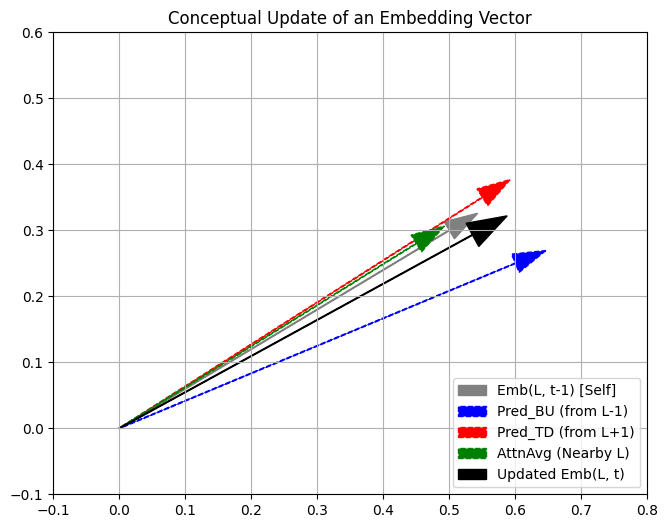

The black vector is the weighted average of the influences from the other (dashed/gray) vectors.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Simplified conceptual state for one level (L) in one column (x)
embedding_L_t_minus_1 = np.array([0.5, 0.3]) # Previous state of this embedding

# Simplified outputs from the contributing pathways (from t-1)
pred_BU_from_L_minus_1 = np.array([0.6, 0.25]) # Bottom-up prediction for current L
pred_TD_from_L_plus_1 = np.array([0.55, 0.35])# Top-down prediction for current L
attn_avg_nearby_L = np.array([0.45, 0.28])  # Lateral attention from neighbors at L

# Example weights for the four contributions (these would be learned or fixed)
w_bu = 0.3
w_td = 0.2
w_prev = 0.4 # Weight for its own previous state (temporal smoothing)
w_attn = 0.1
# Ensure weights sum to 1 (or are normalized)
total_w = w_bu + w_td + w_prev + w_attn
w_bu, w_td, w_prev, w_attn = w_bu/total_w, w_td/total_w, w_prev/total_w, w_attn/total_w

# Calculate the updated embedding at time t
embedding_L_t = (w_bu * pred_BU_from_L_minus_1 +
                 w_td * pred_TD_from_L_plus_1 +
                 w_prev * embedding_L_t_minus_1 +
                 w_attn * attn_avg_nearby_L)

print(f"Embedding at L (t-1): {embedding_L_t_minus_1}")
print(f"Bottom-up Prediction:   {pred_BU_from_L_minus_1}")
print(f"Top-down Prediction:    {pred_TD_from_L_plus_1}")
print(f"Attention Avg Nearby: {attn_avg_nearby_L}")
print(f"Updated Embedding at L (t): {embedding_L_t}")

# Visualization
fig, ax = plt.subplots(figsize=(8,6))
ax.arrow(0, 0, embedding_L_t_minus_1[0], embedding_L_t_minus_1[1],
         head_width=0.03, head_length=0.05, fc='gray', ec='gray', label='Emb(L, t-1) [Self]')
ax.arrow(0, 0, pred_BU_from_L_minus_1[0], pred_BU_from_L_minus_1[1],
         head_width=0.03, head_length=0.05, fc='blue', ec='blue', label='Pred_BU (from L-1)', linestyle='--')
ax.arrow(0, 0, pred_TD_from_L_plus_1[0], pred_TD_from_L_plus_1[1],
         head_width=0.03, head_length=0.05, fc='red', ec='red', label='Pred_TD (from L+1)', linestyle='--')
ax.arrow(0, 0, attn_avg_nearby_L[0], attn_avg_nearby_L[1],
         head_width=0.03, head_length=0.05, fc='green', ec='green', label='AttnAvg (Nearby L)', linestyle='--')

ax.arrow(0, 0, embedding_L_t[0], embedding_L_t[1],
         head_width=0.04, head_length=0.06, fc='black', ec='black', label='Updated Emb(L, t)')

ax.set_xlim(-0.1, 0.8)
ax.set_ylim(-0.1, 0.6)
ax.set_title('Conceptual Update of an Embedding Vector')
ax.legend(loc='lower right')
ax.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("The black vector is the weighted average of the influences from the other (dashed/gray) vectors.")

## 5. Key Design Decisions in GLOM

The GLOM architecture, while conceptual, involves several important design choices that influence how it would function and learn. These decisions address fundamental questions about representing hierarchical information in a neural network.

### 5.1 How Many Levels are There?

**Fixed Depth:** GLOM assumes that the part-whole hierarchy it represents has a **fixed depth**. The paper suggests a reasonable number of embedding levels would be **about five**. [11]

**Example Hierarchy with Five Levels:** [11]
1.  **Level 0 (Lowest):** Sub-sub-parts (e.g., pupil, white of an eye)
2.  **Level 1:** Sub-parts (e.g., eyes, in a face that is a part of a person)
3.  **Level 2:** Parts (e.g., faces, in a scene with people as objects)
4.  **Level 3:** Objects (e.g., people)
5.  **Level 4 (Highest):** Scene

**Flexible Mapping for Deeper Real-World Hierarchies:**
Real-world hierarchies can be much deeper (e.g., from stars down to atomic nuclei). To handle this vast range with a fixed number of levels, GLOM proposes a **flexible mapping** between entities in the world and its own internal levels [Hinton, 1990, as cited in 11]. This means the same neurons could represent different scales at different times.
-   **Example:** The same neurons could be used for stars at one time and for atomic nuclei at another. This also facilitates analogies between structures at very different scales (e.g., solar systems and atoms). [11]
-   **Remapping:** If finer details are required than the current mapping allows (e.g., details of iris dilation when the 'eye' is already at the lowest level), people (and GLOM would need to) probably remap the world onto their hardware. For instance, the 'face' could become the 'scene,' allowing the 'eye' to be represented at a higher level, freeing up lower levels for iris details. [11]

**Sharing Neural Nets Across Levels:**
An interesting question is whether the bottom-up and top-down neural nets can be shared not just across locations (columns) but also across *levels*.
-   **Vision's Fractal Nature:** This might work for vision, which is more fractal (self-similar at different scales) than, say, language processing where entities like phonemes and words have very different properties. [11]
-   **Advantage of Sharing:** If nets are shared across levels, the vector representation for a 'face' when it's an 'object' would be forced to be consistent with its representation when it's a 'part' (in a larger scene). This simplifies remapping: one could copy vectors up or down a few levels. [11]

### 5.2 How Fine-Grained are the Locations?

**Options for Granularity:**
Locations (columns in GLOM) could correspond to: [12]
1.  **Pixels:** Very fine-grained, high resolution.
2.  **Image Patches:** Larger regions (e.g., 4x4 pixels, as in [Dosovitskiy et al., 2020]). This is coarser.

**Trade-offs:**
-   **Pixels:** Precise localization, but computationally intensive and many columns.
-   **Patches:** Less computation, fewer columns, but coarser localization.

**Assumption in the Paper:** For simplicity, the paper often assumes the grid of locations remains the same at all levels, but acknowledges this is likely not optimal. [12]

**Changing Granularity Across Levels:**
It's plausible that granularity could change at different embedding levels: [12]
-   **Higher Levels, Larger Stride:** Higher levels in the part-whole hierarchy (representing larger objects/parts) might use a larger stride (i.e., each column at a high level corresponds to a larger area of the input image, or equivalently, fewer high-level columns cover the image).
    -   **Impact on Nets:** If so, the top-down net would need to output multiple predictions for the multiple lower-level locations that fall within one higher-level location. The bottom-up net would need to combine information from all lower-level locations that map to the next level up. [12]

**Multi-Resolution Input for Context and Detail:**
A way to be sensitive to large spatial context while seeing fine detail is to have images at several different spatial resolutions, all with the same number of pixels (conceptually). [12]
-   **Coarsest Image:** Conveys large spatial context, lacks fine detail.
-   **Finest Image:** Conveys fine details, but only for a small region.
If input is structured this way, peripheral locations could cover larger regions (mimicking foveated vision), though the paper ignores this complexity. [12]

### 5.3 Does the Bottom-Up Net Look at Nearby Locations?

**Pure GLOM vs. Extended GLOM:**
-   **Pure Version:** The bottom-up pathway within a column *only* looks at the embedding at the level below *in the same column*. Interactions between columns happen *only* through the lateral attention-weighted averaging at the same level. [12]
-   **Extended Version:** The bottom-up neural net could also look at the embedding vectors at nearby locations (in neighboring columns) at the level below. [12]

**Advantages of Extended Version:**
-   **Richer Context for Bottom-Up:** Allows the bottom-up net to use local context, potentially making more informed predictions for the next level up. This resembles a convolutional neural net where predictions for the next layer are made by a multi-layer net looking at a neighborhood. [12]
-   **Reduced Uncertainty Early:** By looking at other locations, the bottom-up net might reduce uncertainty *before* predicting a distribution for the next level up. [12]

**Disadvantages of Extended Version (Advantages of Pure Version):**
-   **Loss of a Nice Property:** In the pure version, two locations with identical representations at the part level (L-1) will make *exactly the same* bottom-up predictions for the object level (L). If the bottom-up net looks at differing spatial contexts in neighboring columns, this property is lost. [12]
-   **Complexity:** Makes the bottom-up pathway more complex.
-   **Alternative for Uncertainty Reduction:** The paper argues that a similar reduction in uncertainty (as offered by the extended bottom-up net) *can* be achieved in the pure version *after* the initial bottom-up prediction, when the attention-weighted smoothing combines uncertain predictions from multiple locations. This assumes the bottom-up net can represent uncertainty in its predictions. [12]

### 5.4 How Does the Attention Work?

**Simplest Form of Attention Weighting:** [13]
As one of the four contributions to updating an embedding (specifically, the lateral interaction), GLOM uses attention-weighted averaging of embeddings from nearby locations at the same level.
The weight `w_xy` that location `x` gives to the embedding at location `y` (at level `L`) is:
`w_xy = exp(β * L_x ⋅ L_y) / Σ_z exp(β * L_x ⋅ L_z)`
Where:
-   `L_x`, `L_y` are the embedding vectors at level `L` for locations `x` and `y` respectively.
-   `L_x ⋅ L_y` is the scalar product (dot product) of the two embedding vectors (measuring their similarity).
-   `z` indexes all the locations that location `x` attends to at level `L`.
-   `β` is an "inverse temperature" parameter determining the sharpness of attention. A higher `β` makes the attention more focused on the most similar embeddings. `β` could increase as GLOM settles to a firm interpretation. [13]
This form of attention has been used successfully in a system called "ACNe" [Sun et al., 2020a, as cited in 13].

**Relation to Markov Random Fields and Boundaries:**
Pioneering work on Markov Random Fields for image segmentation [Geman and Geman, 1984] used the presence of a boundary between pixels `x` and `y` to prevent `x` from attending to `y`. A boundary itself depends on intensities at other locations. Similarly, early work on learning spatially coherent properties [Becker and Hinton, 1993] used boundaries to select expert interpolators. GLOM needs to integrate such concepts of boundaries into its attention mechanism. [13]

### 5.5 The Visual Input

**Primary, Lowest-Level Embedding:**
-   **Option 1: Raw Patches:** A patch of raw visual input could directly define the bottom-level embedding by vectorizing intensities. [13]
-   **Option 2: CNN Output (More Sensible):** Apply a convolutional neural net (CNN) to a larger region of the image first. The output of this CNN would then be the primary, lowest-level embedding at each location. [13]

**Inference Problem for Lowest-Level Embedding:**
The CNN provides an open-loop way to solve an inference problem: "What lowest-level embedding for that location would be able to reconstruct the pixel intensities using the learned neural field shared by all locations?" [13]
Once this initial lowest-level embedding is available (e.g., from the CNN), it can be further **refined in a closed loop** by backpropagating the reconstruction error from the shared neural field. [Williams et al., 1995, as cited in 13].

**Direct Input to Higher Levels?:**
Visual input doesn't need to be confined to the primary embedding layer. A coarser scale CNN operating on a lower-resolution image could provide useful hints for higher-level embeddings. [14]
-   **Example:** A pale vertical oval with a darker horizontal band (a coarse feature) suggests a face [Viola and Jones, 2004]. This coarse CNN output could directly initialize higher-level (e.g., face-level) embeddings. [14]
-   **Biological Analogy:** The visual part of the thalamus has direct connections to multiple levels in the hierarchy of visual areas. [14]


## 6. Representing Color, Texture, and Shape in GLOM

GLOM aims to create rich, holistic representations of objects and their parts. This means encoding not just their presence or category, but also their visual attributes like color, texture, and overall shape. The concept of 'islands of identical embeddings' is central to how GLOM achieves this.

**The Idea of "Compound" Attributes at the Object Level:**
A key motivation for GLOM was to represent how an object (a 'whole') can have a 'compound' attribute that summarizes the potentially varied attributes of its parts. [14]

**Color:**
-   **Problem:** Consider an object whose individual parts are, for example, entirely pale green or entirely mauve. What is the color of the *whole object*?
-   **GLOM's Solution:** The whole object has a compound color, which might be described as "pale-green-or-mauve." Critically, at the *object level* in GLOM's hierarchy, **every location (column) belonging to this object has exactly the same compound color representation in its embedding.** The object is, in essence, "pale-green-and-mauve all over" at this level of description. [14]
-   **Attention Implication:** When deciding which other locations at the object level to attend to (for lateral communication), preference would be given to locations with a similar compound color. [14]

**Texture:**
-   **Analogous Idea:** A similar principle applies to textures.
-   **Individual Texture Elements:** These have their own shapes, poses, and spatial relationships.
-   **Object-Level Texture:** An object with a textured surface has **exactly the same texture representation everywhere at the object level** in GLOM. The embedding for the object, across all its constituent locations, would encode this consistent texture (e.g., "uniformly striped" or "consistently bumpy"). [14]

**Shape:**
-   **Extension to Shapes:** GLOM extends this idea of compound attributes to shapes.
-   **Differing Parts:** An object may have parts that are very different from one another in shape (e.g., a teapot has a spout, a handle, a lid, and a body, all with distinct shapes).
-   **Object-Level Compound Shape:** However, at the *object level*, the object itself has **exactly the same compound shape representation in all of the locations that it occupies.** This compound shape isn't just a simple outline; it's a richer, holistic description that is consistent across the entire 'island' representing the object. [14]

**How Islands Encode These Attributes:**
1.  **Embedding Vectors:** The shared, identical embedding vector within an island at a particular level (e.g., the 'teapot object' level) carries the information about these compound attributes (color, texture, shape of the teapot).
2.  **Consistency:** The iterative update process, especially the lateral attention mechanism, enforces this consistency. Locations that are part of the same object will tend to converge to an embedding that reflects the object's overall characteristics.
3.  **Implicit Segmentation:** The formation of these islands, each with a distinct and consistent set of attributes in its embedding, effectively segments the image into meaningful regions corresponding to parts and wholes.

**Visualization: Attributes of an Island**
Imagine an image containing a red, rough-textured sphere.
-   At the object level corresponding to the sphere, all columns (locations) that make up the sphere would form an island.
-   The shared embedding vector for this island would encode:
    -   Compound Color: "Red"
    -   Compound Texture: "Rough"
    -   Compound Shape: Information representing "Spheroid"
Even if lower levels describe individual bumps or slight color variations, the object-level embedding captures the dominant, consistent attributes of the sphere as a whole.

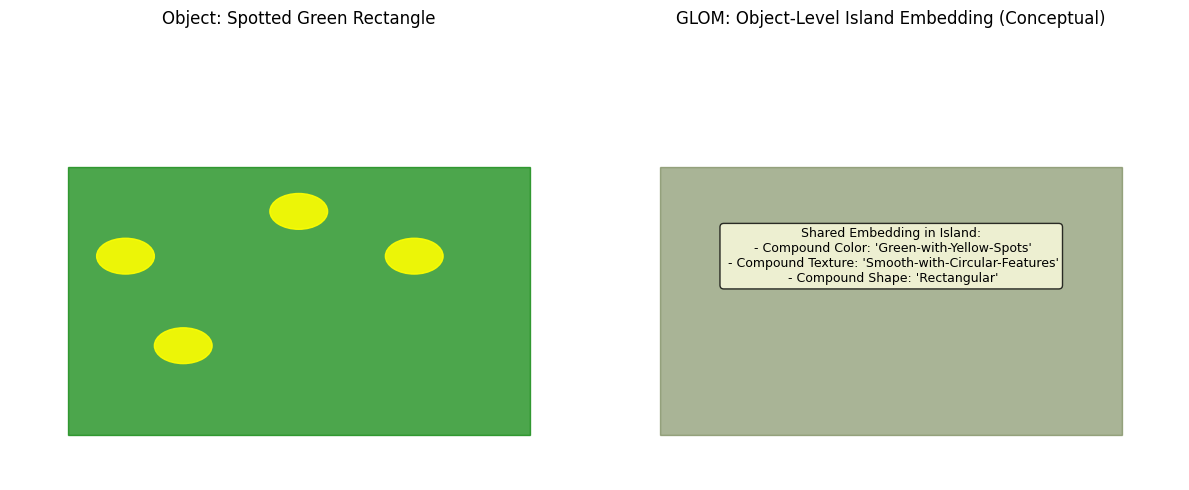

At the object level, GLOM would represent the 'Spotted Green Rectangle' with a single, consistent embedding across all its locations (the island). 
This embedding captures the 'compound' attributes of the whole object.


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Object: A "Spotted Green Rectangle"
# Attributes:
# - Color: Green (dominant), with Yellow spots (parts)
# - Texture: Smooth (dominant), with circular spots
# - Shape: Rectangular

# --- Visualization of the object itself ---
ax[0].set_title('Object: Spotted Green Rectangle')
main_rect = Rectangle((0.1, 0.1), 0.8, 0.6, color='green', alpha=0.7)
ax[0].add_patch(main_rect)

spots_coords = [(0.3, 0.3), (0.7, 0.5), (0.5, 0.6), (0.2, 0.5)]
for i, (x, y) in enumerate(spots_coords):
    spot = Ellipse((x, y), 0.1, 0.08, color='yellow', alpha=0.9)
    ax[0].add_patch(spot)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].axis('off')

# --- Conceptual GLOM Island Representation ---
ax[1].set_title('GLOM: Object-Level Island Embedding (Conceptual)')
# Represent the island as a single colored area
island_representation = Rectangle((0.1, 0.1), 0.8, 0.6, color='darkolivegreen', alpha=0.5) # Mixed color
ax[1].add_patch(island_representation)

# Text describing the shared embedding within the island
embedding_text = "Shared Embedding in Island:\n"
embedding_text += " - Compound Color: 'Green-with-Yellow-Spots'\n"
embedding_text += " - Compound Texture: 'Smooth-with-Circular-Features'\n"
embedding_text += " - Compound Shape: 'Rectangular'"

ax[1].text(0.5, 0.5, embedding_text, ha='center', va='center', fontsize=9,
           bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="black", alpha=0.8))

ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].axis('off')

plt.tight_layout()
plt.show()

print("At the object level, GLOM would represent the 'Spotted Green Rectangle' with a single, consistent embedding across all its locations (the island). ")
print("This embedding captures the 'compound' attributes of the whole object.")

## 7. Cluster Discovery (Capsules) vs. Cluster Formation (GLOM)

A key difference between traditional capsule models and GLOM lies in how they identify and represent groups of features or parts that belong together. This is often framed as discovering pre-existing clusters versus actively forming clusters.

**Capsule Models (e.g., EM Capsule Model [Hinton et al., 2018]): Cluster Discovery**
1.  **Identifying Wholes by Clustering Part Votes:**
    *   In models like the EM capsule model, lower-level capsules (representing parts like a nose or a mouth) generate "votes" for the pose of a higher-level whole (e.g., a face). These votes are essentially predictions of the whole's instantiation parameters. [14]
    *   The system then looks for **clusters** among these vector votes. If a significant number of part-votes agree (i.e., form a tight cluster in the pose space), it indicates the presence of the whole. The center of this cluster might represent the pose of the detected whole.
2.  **Immutable Votes (Problematic):**
    *   A challenge highlighted in the GLOM paper is that these vector votes from parts are often **fixed or immutable** during the routing or clustering process for a given input. [14]
    *   This can be problematic if a part has an under-determined pose. For example, a circular eye doesn't have a specific orientation by itself. Its contribution to the pose of the face depends on whether it's a left or right eye, which might not be known initially. Its vote for the face's scale might be unimodal, but its vote for location might be ambiguous. [14]
3.  **Discovering in Immutable Data:**
    *   The process is akin to discovering clusters in a static, pre-existing dataset of votes. The parts cast their votes, and the higher level tries to find consensus among them.

**GLOM: Cluster Formation**
1.  **Dynamic Interaction and Formation:**
    *   In GLOM, the embedding vector of a location at a lower level (L-1) does *not* cast an immutable vote for the embedding at level L. Instead, it provides a **bottom-up vector contribution** that is combined with other contributions (top-down, lateral attention, previous state). [15]
    *   The 'islands' of similar embedding vectors (which are the clusters representing parts/wholes) are not discovered in immutable data. They are **formed** by the dynamic interaction between an intra-level process that favors islands of similarity and the dynamically changing suggestions coming from the embeddings at adjacent levels (bottom-up and top-down). [15]
2.  **Evolving Contributions:**
    *   The bottom-up contribution from a lower level can start vague and become sharper over time steps as top-down and lateral contextual information progressively refines the lower-level embedding itself. [15]
    *   This means the "suggestions" from lower levels are not fixed but co-evolve with the representations at other levels and locations.
3.  **No Pre-defined Clusters to Find:**
    *   GLOM doesn't assume pre-defined categories or a fixed number of clusters it needs to assign parts to. The islands (clusters) emerge from the self-organizing process of embedding updates.
    *   Hierarchical Bayesian concerns about finding the correct number of clusters are addressed by effectively starting with one island per location and then reducing the number of distinct islands by making embedding vectors agree through the update rules. This reduction occurs in a continuous space. [23]

**Key Differences Summarized:**

| Feature             | Capsule Models (Cluster Discovery)                     | GLOM (Cluster Formation)                                  |
|---------------------|--------------------------------------------------------|-----------------------------------------------------------|
| **Part Contributions** | Fixed/immutable votes for whole's pose/embedding.      | Dynamic vector contributions, refined over time.            |
| **Cluster Nature**  | Discovered in a static set of votes.                   | Formed through iterative, interactive updates.            |
| **Flexibility**     | Can be rigid if part poses are initially ambiguous.    | More flexible; part representations co-evolve with whole. |
| **Process**         | Parts vote -> Whole finds consensus.                   | Parts & Wholes negotiate & co-adapt representations.        |

**Analogy:**
-   **Capsule Models (Discovery):** Imagine several people independently pointing to where they think a hidden object is. You then look for a spot where many fingers are pointing.
-   **GLOM (Formation):** Imagine a group of people in a dark room trying to arrange themselves into a specific shape. They communicate with their neighbors and adjust their positions based on local feedback and a general idea of the overall shape, gradually forming the desired pattern.

This shift from discovering pre-defined clusters to actively forming them through dynamic interactions is a significant conceptual step that GLOM proposes, aiming for more flexible and robust representation of part-whole hierarchies.

## 8. Training GLOM: Learning to Form Islands

GLOM, being a conceptual framework, doesn't have a definitive, implemented training procedure. However, the paper outlines how it *could* be trained, drawing upon established and emerging machine learning techniques, primarily in a self-supervised manner.

**Overall Training Objective:**
The primary objective is to learn neural network weights (for the bottom-up encoders, top-down decoders, and potentially temporal dynamics nets) such that the system can effectively parse images into part-whole hierarchies represented by islands of identical embeddings. The paper suggests a multi-faceted approach to achieve this:

### 8.1 Reconstruction of Uncorrupted Images (Denoising Autoencoder Principle)
**Mechanism:**
GLOM can be trained to reconstruct at its output the **uncorrupted version of an input image from which some regions have been removed (corrupted).** [16]
-   This is a direct application of the denoising autoencoder principle. The "corruption" is the removal of image regions.
-   The entire GLOM architecture (through its iterative settling process) acts as a large, complex autoencoder.

**Purpose:**
1.  **Information Preservation:** This objective ensures that information about the input is preserved during the forward pass (the iterative settling of embeddings).
2.  **Learning Meaningful Representations:** If the removed regions are sufficiently large, the system must identify familiar objects and understand their structure to successfully fill in the missing parts. This encourages the learning of high-level, meaningful features and relationships. [16]

### 8.2 Regularizers for Encouraging Island Formation
Simply reconstructing the image might not be enough to force the explicit formation of islands of *near identical* vectors. Therefore, additional regularizers are needed.

**1. Encouraging Similarity (Naive Approach and its Pitfall):**
   - A naive regularizer might simply encourage similarity between the embeddings of nearby locations.
   - **Problem (Collapse):** This can cause representations to collapse. All embedding vectors might become very small or identical across the entire image, making them useless. The reconstruction network would then compensate by using very large weights, which is not a good solution. [16]

**2. Contrastive Learning to Prevent Collapse:**
   - **Mechanism:** Contrastive learning [Becker and Hinton, 1992; Paccanaro and Hinton, 2001; van den Oord et al., 2018, as cited in 16] is proposed to solve the collapse problem. It tries to make representations that *should* agree (positive pairs) be close, while maintaining separation between representations that *should not* agree (negative pairs). [16]
   - **Applying to GLOM:**
     - **Positive Pairs:** Two locations `x` and `y` at a level `L` should have similar embeddings *only if they belong to the same entity at level L*.
     - **Negative Pairs:** If they belong to different entities at level `L`, their embeddings should be significantly different. [17]
   - **Context for Contrastive Learning:** Recent work [Jabri et al., 2020] using patch similarity along object trajectories in video to define positive/negative pairs has shown impressive performance, which is relevant for GLOM. [17]

**3. Agreement-Based Regularizers (More Direct Island Encouragement):**
   - **Mechanism:** Regularize the bottom-up and top-down neural networks by encouraging each of them to predict the **consensus opinion**. [17]
   - The consensus opinion is defined as the **weighted geometric mean** of the predictions coming from:
     1.  The top-down network (from level L+1).
     2.  The bottom-up network (from level L-1).
     3.  The attention-weighted average of embeddings at nearby locations (at level L).
     4.  The previous state of the embedding (at level L).
   - Training the inter-level predictions (bottom-up and top-down) to agree with this consensus will directly make the islands found during feed-forward inference more coherent. [17]

**Will Agreement-Based Regularizers Cause Collapse?**
-   If not accompanied by training the inter-level predictions to be *different* for negative examples (where consensus is for unrelated spatial contexts), there's a risk of collapse. [17]
-   **Mitigation:**
    -   Layer or batch normalization might reduce the tendency to collapse. [17]
    -   **Achievability of the Goal:** A more important consideration is that if an embedding at one location is free to choose which *other* embeddings it should resemble (via the attention mechanism), the goal of forming islands of *identical* vectors can be achieved almost perfectly. This near-perfect achievability should greatly reduce the tendency towards collapse, especially when combined with the deep denoising autoencoder objective and other recent tricks (e.g., [Grill et al., 2020; Chen and He, 2020]). This might even eliminate the need for explicit negative examples in the contrastive learning part. [17-18]

**Overall Training Loop (Conceptual):**
1.  Take an input image.
2.  Corrupt it by removing some regions.
3.  Feed the corrupted image to GLOM (or its initial CNN features).
4.  Let GLOM iterate for several time steps, updating embeddings at all levels and locations.
5.  Calculate the reconstruction loss between GLOM's output (reconstructed image from final embeddings) and the original uncorrupted image.
6.  During the iterations, or based on the final settled embeddings, calculate regularizer losses:
    *   Contrastive loss to push apart embeddings of different entities and pull together embeddings of the same entity at each level.
    *   Agreement loss to encourage bottom-up/top-down predictions to match the consensus embedding.
7.  Combine these losses and backpropagate through the entire iterative process (or a truncated version) to update the weights of the bottom-up and top-down networks.

**Simplified Visualization: Contrastive Loss for Island Formation**

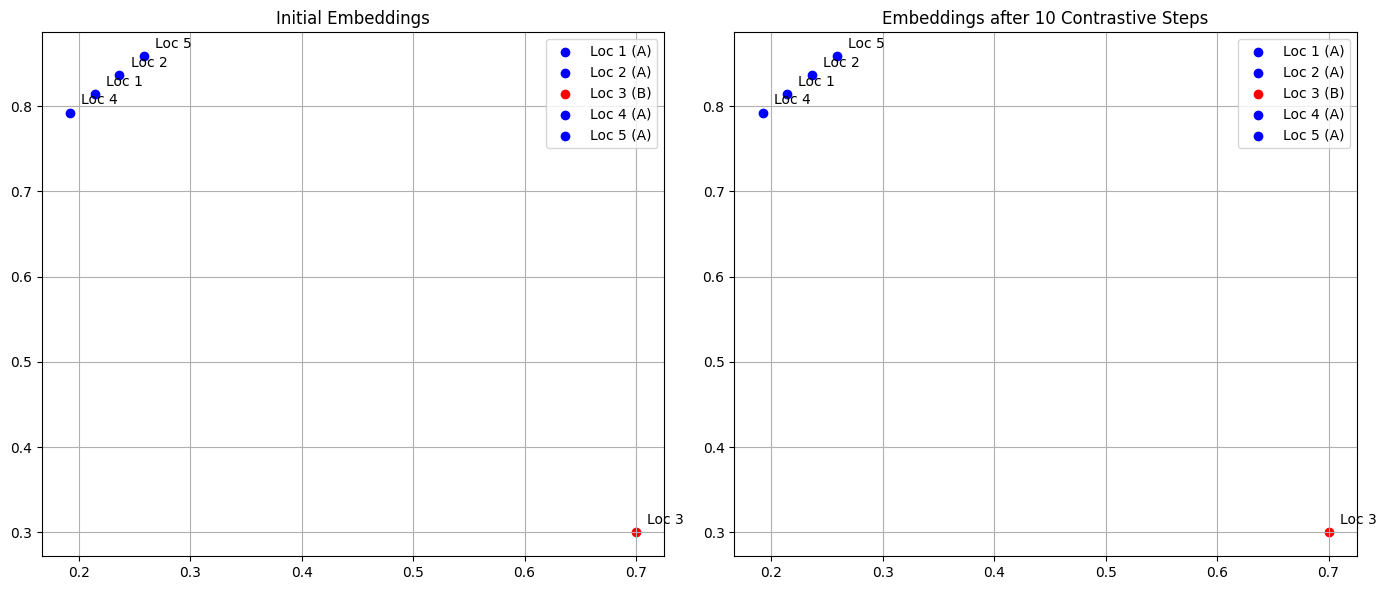

Contrastive learning helps embeddings belonging to the same entity (Island A or B) cluster together, while pushing different entities apart.
This encourages the formation of distinct 'islands' of embeddings.


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Imagine a 1D slice of GLOM at a particular level L
# Embeddings for 5 locations (columns)
locations = ['Loc 1', 'Loc 2', 'Loc 3', 'Loc 4', 'Loc 5']
# Assume Loc 1, 2 belong to Island A; Loc 3 to Island B; Loc 4, 5 to Island A
entity_assignment = ['A', 'A', 'B', 'A', 'A']

# Initial 2D embeddings (randomly for demonstration)
embeddings_l = {
    'Loc 1': np.array([0.2, 0.8]),
    'Loc 2': np.array([0.25, 0.85]),
    'Loc 3': np.array([0.7, 0.3]),  # Should be different
    'Loc 4': np.array([0.15, 0.75]),
    'Loc 5': np.array([0.3, 0.9])
}

def simplified_contrastive_update(embeddings, assignments, lr=0.1, pull_strength=0.2, push_strength=0.1):
    updated_embeddings = embeddings.copy()
    loc_keys = list(embeddings.keys())
    for i in range(len(loc_keys)):
        anchor_loc = loc_keys[i]
        anchor_emb = embeddings[anchor_loc]
        anchor_assignment = assignments[i]

        for j in range(len(loc_keys)):
            if i == j: continue
            other_loc = loc_keys[j]
            other_emb = embeddings[other_loc]
            other_assignment = assignments[j]

            if anchor_assignment == other_assignment: # Positive pair
                # Pull them closer
                direction = other_emb - anchor_emb
                updated_embeddings[anchor_loc] += lr * pull_strength * direction
            else: # Negative pair
                # Push them apart
                direction = anchor_emb - other_emb
                # Normalize to avoid huge steps if they are already far
                dist = np.linalg.norm(direction)
                if dist > 0 and dist < 0.5: # Only push if too close
                    updated_embeddings[anchor_loc] += lr * push_strength * (direction / (dist + 1e-5))
    return updated_embeddings

num_training_steps = 10
history = [embeddings_l.copy()]
current_embeddings = embeddings_l.copy()

for step in range(num_training_steps):
    current_embeddings = simplified_contrastive_update(current_embeddings, entity_assignment)
    history.append(current_embeddings.copy())

# Plotting the evolution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = {'A': 'blue', 'B': 'red'}

# Initial state
axes[0].set_title('Initial Embeddings')
for i, loc in enumerate(locations):
    emb = history[0][loc]
    axes[0].scatter(emb[0], emb[1], color=colors[entity_assignment[i]], label=f'{loc} ({entity_assignment[i]})' if loc not in axes[0].get_legend_handles_labels()[1] else "")
    axes[0].text(emb[0]+0.01, emb[1]+0.01, loc)
axes[0].grid(True)
axes[0].legend()

# Final state
axes[1].set_title(f'Embeddings after {num_training_steps} Contrastive Steps')
for i, loc in enumerate(locations):
    emb = history[-1][loc]
    axes[1].scatter(emb[0], emb[1], color=colors[entity_assignment[i]], label=f'{loc} ({entity_assignment[i]})' if loc not in axes[1].get_legend_handles_labels()[1] else "")
    axes[1].text(emb[0]+0.01, emb[1]+0.01, loc)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

print("Contrastive learning helps embeddings belonging to the same entity (Island A or B) cluster together, while pushing different entities apart.")
print("This encourages the formation of distinct 'islands' of embeddings.")

## 9. Representing Coordinate Transformations and Pose

A fundamental challenge in vision is recognizing objects regardless of their viewpoint (position, orientation, scale). This requires understanding and representing **coordinate transformations** – how an object's or part's appearance changes as its pose relative to the viewer changes.

**Importance of Intrinsic Coordinate Frames:**
Neural networks generally work much better if they represent the details of a shape relative to its **intrinsic coordinate frame** rather than relative to a frame based on the camera or the world. [18, citing Taylor et al., 2007; Deng et al., 2020].
-   **Example:** The shape of a human hand is complex. It's easier to describe the arrangement of fingers relative to the palm (the hand's intrinsic frame) than to describe their absolute pixel coordinates in an image, which change drastically with every hand movement.

**Representing Location and Pose:**
1.  **Location Encoding:**
    -   Traditional methods use two scalars (x, y) for location. However, work on neural fields (e.g., [Sitzmann et al., 2020; Mildenhall et al., 2020]) has shown that **highly redundant representations of location** work much better. [18]
    -   A common technique is to use positional encoding, like sine and cosine waves of various frequencies applied to the coordinates (similar to Transformers).

2.  **Pose Encoding (Beyond Matrices/Quaternions):**
    -   In computer graphics, 4x4 matrices or quaternions are commonly used to represent pose (3D rotation and translation).
    -   **Challenge for Neural Nets:** While mathematically sound, these representations might not be ideal for neural networks, especially for representing *uncertainty* about pose. For example, a flattened 4x4 matrix vector doesn't easily allow representing certainty about some aspects of pose (e.g., scale) and uncertainty about others (e.g., in-plane rotation). [18]
    -   **GLOM's Approach (Hypothetical):** The paper suggests there may be highly redundant representations for the non-translational degrees of freedom (rotation, scale, etc.) of a coordinate transform that work much better in a neural net. The pose of a part (the coordinate transform between the retina/camera and the part's intrinsic frame) would be represented by a **subsection of the embedding vector** for that part. [18]

**Learning Part-Whole Transformations:**
-   A multi-layer neural network, whose weights capture the viewpoint-invariant coordinate transform between a part and a whole, can then operate on the pose vector of the part to predict the pose vector of the whole. [18]
-   This is where GLOM connects to earlier capsule ideas: the neural nets between levels in GLOM are essentially learning these part-whole coordinate transformations.

**Universal Capsules and Entangled Representations:**
-   **Challenge with Part Identity:** If a separate capsule (or a distinct neural pathway) is allocated for each *type* of part, the network implementing the part-whole transform depends on the *identity* of the part. This was a reason for allocating separate capsules in earlier models. [18]
-   **GLOM's Universal Capsule Idea:** In GLOM, with the concept of 'universal capsules' (where part-identity is part of the activity vector), the *entire part-level vector* of a location (which includes identity, pose, etc.) needs to be provided as input to the bottom-up neural net that computes the part-whole coordinate transform. This simplifies the architecture design: one doesn't need to designate separate parts of the embedding vector for pose versus other aspects. [19]
-   **Entangled Representations:** The neural net, learned by stochastic gradient descent, can learn to implicitly disentangle or use these components as needed. Individual components of the embedding vector can be tuned to combinations of pose, identity, deformation, texture, etc. [19]
    -   **Example:** How can a bottom-up prediction from a diagonal line express the opinion that the whole is *either* a tilted square *or* an upright diamond? To express this distribution using activities of basis functions, we need basis functions tuned to *combinations* of identity and pose. [19]

**Generalization Across Viewpoints with Universal Capsules:**
-   Abandoning explicit matrix/quaternion representations for pose might seem to compromise generalization across viewpoints.
-   However, GLOM's 'universal capsules' (the shared embeddings at each location/level) will have seen many different types of objects from many different viewpoints.
-   A new object will likely be well-approximated by a weighted average of familiar types, all of which have learned to model the effects of viewpoint. The weights in this average will be the same for all viewpoints.
-   Therefore, even if a novel object is seen from only a single viewpoint, a universal capsule in GLOM may be able to recognize it from radically different viewpoints. [19]
This is a key difference from standard CNNs: GLOM is *forced* to model coordinate transforms between parts and wholes correctly to use the simple averaging operation (island formation) at the level of the whole. The viewpoint invariance of these part-whole spatial relationships makes generalization to new viewpoints possible. [20]

**Visualization: Coordinate Transformation**
Imagine a 'part' (e.g., a wheel) in its own coordinate frame. To place it on a 'whole' (e.g., a car), its coordinates need to be transformed (rotated, translated, scaled) into the car's coordinate frame.

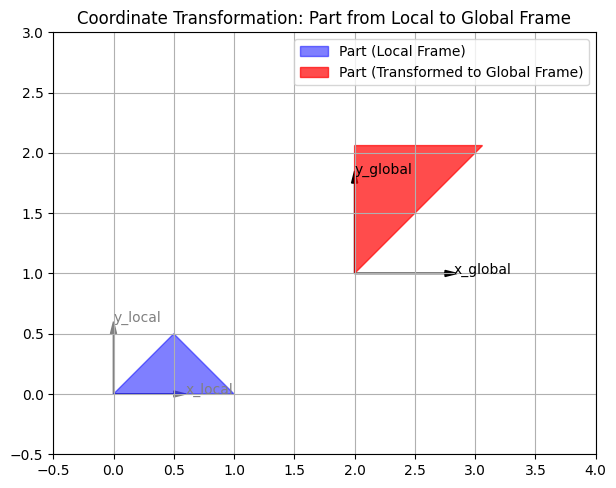

GLOM's internal networks would learn these types of transformations between part and whole frames.
The 'pose vector' in the embedding would parameterize this transformation.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define a simple part (e.g., a triangle) in its own coordinate frame
part_coords_local = np.array([
    [0, 0, 1],  # Point 1 (x, y, homogeneous coordinate)
    [1, 0, 1],  # Point 2
    [0.5, 0.5, 1] # Point 3
]).T # Transpose to make it 3xN

# Define a transformation matrix (Scale, Rotate, Translate)
scale = 1.5
angle_deg = 45
translate_x, translate_y = 2, 1

theta = np.radians(angle_deg)
cos_t, sin_t = np.cos(theta), np.sin(theta)

transform_matrix = np.array([
    [scale * cos_t, -scale * sin_t, translate_x],
    [scale * sin_t,  scale * cos_t, translate_y],
    [0,              0,             1]
])

# Apply the transformation
part_coords_global = np.dot(transform_matrix, part_coords_local)

# Plotting
fig, ax = plt.subplots(figsize=(7, 7))

# Plot local coordinate system axes
ax.arrow(0, 0, 0.5, 0, head_width=0.05, head_length=0.1, fc='gray', ec='gray')
ax.text(0.6, 0, 'x_local', color='gray')
ax.arrow(0, 0, 0, 0.5, head_width=0.05, head_length=0.1, fc='gray', ec='gray')
ax.text(0, 0.6, 'y_local', color='gray')

# Plot part in local frame
local_polygon = Polygon(part_coords_local[:2,:].T, closed=True, color='blue', alpha=0.5, label='Part (Local Frame)')
ax.add_patch(local_polygon)

# Plot global coordinate system axes (conceptually, where the whole resides)
ax.arrow(translate_x, translate_y, 0.5*scale, 0, head_width=0.05, head_length=0.1, fc='black', ec='black')
ax.text(translate_x + 0.55*scale, translate_y, 'x_global', color='black')
ax.arrow(translate_x, translate_y, 0, 0.5*scale, head_width=0.05, head_length=0.1, fc='black', ec='black')
ax.text(translate_x, translate_y + 0.55*scale, 'y_global', color='black')

# Plot part in global frame
global_polygon = Polygon(part_coords_global[:2,:].T, closed=True, color='red', alpha=0.7, label='Part (Transformed to Global Frame)')
ax.add_patch(global_polygon)

ax.set_xlim(-0.5, 4)
ax.set_ylim(-0.5, 3)
ax.set_title('Coordinate Transformation: Part from Local to Global Frame')
ax.legend()
ax.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("GLOM's internal networks would learn these types of transformations between part and whole frames.")
print("The 'pose vector' in the embedding would parameterize this transformation.")

## 10. Representing Uncertainty in GLOM

Visual perception is inherently uncertain. Objects can be occluded, ambiguous, or viewed under poor lighting. A robust vision system must not only recognize entities but also represent its uncertainty about their properties (like pose or identity).

**Why Simple Embeddings are Not Enough for Uncertainty:**
It's tempting to imagine that individual components of an embedding vector directly correspond to meaningful variables (e.g., one component for x-position, another for object class). However, this direct mapping makes it hard to represent and combine uncertainty from multiple sources correctly. [20]

**Representing Probability Distributions over Entities:**
GLOM needs to represent M-dimensional entities (e.g., a 6D pose, a distribution over classes) in a way that different sources of information can contribute *probability distributions* over this M-dimensional space, rather than just point estimates. [20]

**1. Population Coding with Gaussian Tuning (Williams and Agakov, 2002):** [20]
   - **Mechanism:** Use a population of `N >> M` neurons, each of which is tuned to a Gaussian function (a bump) in the M-dimensional entity space.
   - **Log Probability:** If we consider the log probability, each neuron corresponds to a parabolic bump in log-probability space. This bump can be wide in some directions (high uncertainty) and narrow in others (low uncertainty). It could even be a horizontal ridge (infinitely wide, representing complete uncertainty along some dimensions).
   - **Combining Information:** The activity of a neuron (its firing rate) acts as a vertical scaling of its parabolic bump. To combine information from multiple sources (or multiple active neurons), we simply *add up* all the scaled bumps. The sum of parabolas is another parabola, which represents the log of the unnormalized Gaussian distribution represented by the entire population of `N` neurons.
   - **Benefit:** Sources of information contribute *additively* to the activities of the `N` neurons, which corresponds to *multiplying* their probability distributions.
   - **Learning Tuning:** With a budget of `N` neurons, learning should optimize their tuning (the means and covariances of their Gaussian bumps) to best approximate the predictive distributions justified by the data. For example, if a part can predict the horizontal location of a whole independently of other pose aspects, some neurons might tune to well-spaced values along the horizontal location dimension. [20]

**2. Unibumps for Multi-modal Distributions (Hinton, 2002):** [21]
   - **Gaussian Limitation:** A single Gaussian can only represent unimodal distributions.
   - **Unibump:** A more flexible way to tune neurons is to use a mixture of a Gaussian and a uniform distribution. The log of this is a localized bump called a **unibump**. [21]
     - The sides of a unibump splay out and eventually become horizontal (zero gradient) far from its mean, where the uniform component dominates. This means it makes no contribution to the shape of the overall distribution far from its mean.
   - **Representing Multi-modality:** This allows unibumps to represent multi-modal probability distributions. The sum of one set of nearby unibumps can represent one mode, and the sum of another distant set can represent another mode. The neural activities (scaling factors) control the location and sharpness of each mode separately. [21]
   - **Learned Basis Functions:** The basis functions that neurons actually learn for representing multi-modal log probability distributions in an underlying latent space do not need to be strictly local in that space. [21]

**Binding Problem and Location-Based Encoding:**
-   **No Binding Problem in GLOM:** A crucial point for representing uncertainty is that each location (column in GLOM) assumes it is occupied by at most *one part at each level* of the hierarchy. This means all neural activities in the embedding vector at a given level for a given location refer to the *same part*. The binding of features to entities is done via the location. [21]
-   **Advantage:** This allows a location to use, for example, two different neurons whose tuning curves in the M-dimensional entity space overlap significantly *without causing confusion*, because both neurons' activities are contributing to the description of the *same* entity at that location.
-   **Contrast with Coarse Coding:** This is why traditional coarse coding (where a single population of broadly tuned neurons models several different entities simultaneously) cannot model uncertainty efficiently, as it creates confusion between the properties of different objects. [22, citing Hinton, 1981a]

**Combining Different Sources of Information When Updating Embeddings (Geometric Mean):** [22]
-   The four contributions to an embedding's update (bottom-up, top-down, lateral-attention, previous-state) are far from independent, especially for a static image.
-   **Avoiding Over-Confidence:** To avoid becoming over-confident by treating these dependent sources as independent, it's better to treat them as *alternative paths* for computing the embedding vector from the visual input.
-   **Weighted Geometric Mean:** This justifies taking a **weighted geometric mean** of the distributions predicted by the individual sources, rather than a simple product (which would be appropriate for independent sources).
    -   Taking the geometric mean of distributions corresponds to taking the arithmetic mean of their log probabilities. This aligns with the additive combination of (log) unibumps/Gaussians discussed earlier.
    -   The weights for this geometric mean would need to change during the iterations for a static image. Initially, the bottom-up source is most reliable. Later, top-down and lateral sources improve and should get more weight. This is supported by experiments with Deep Belief Nets [Hinton, 2006]. [22]

**Visualization: Unimodal vs. Multimodal Distribution**

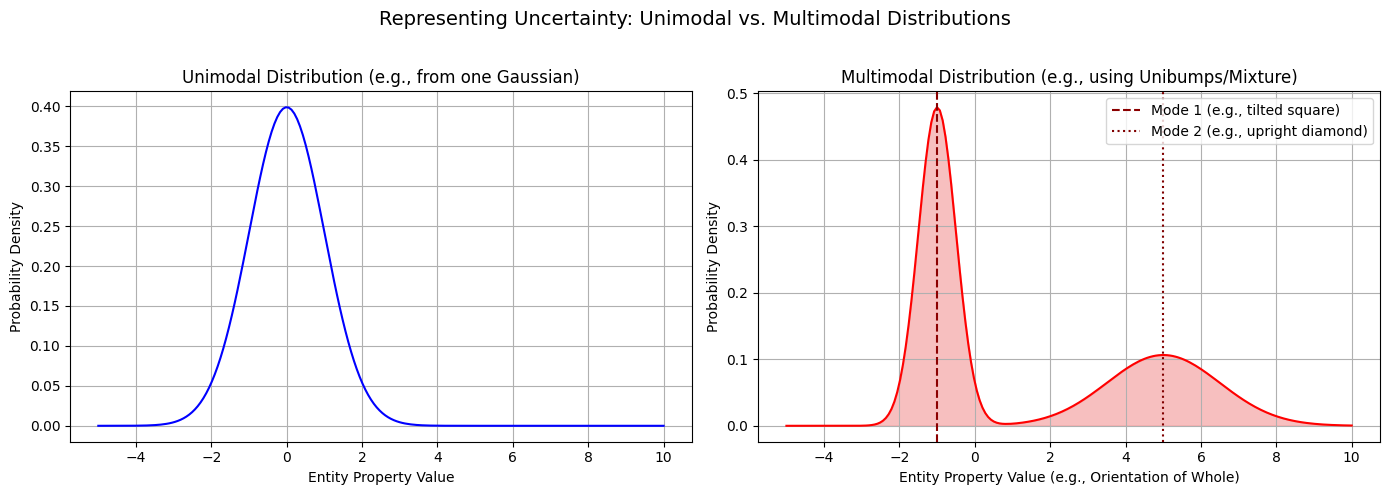

GLOM needs to represent such distributions over pose, identity, etc. 
For example, a diagonal line part could predict a multimodal distribution for the whole's orientation (tilted square OR upright diamond).


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

x_axis = np.linspace(-5, 10, 200)

# Unimodal Gaussian distribution
mean1 = 0
std1 = 1
unimodal_pdf = norm.pdf(x_axis, mean1, std1)

# Multimodal distribution (mixture of two Gaussians)
mean2a = -1
std2a = 0.5
mean2b = 5
std2b = 1.5
multimodal_pdf = 0.6 * norm.pdf(x_axis, mean2a, std2a) + 0.4 * norm.pdf(x_axis, mean2b, std2b)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(x_axis, unimodal_pdf, color='blue')
axes[0].set_title('Unimodal Distribution (e.g., from one Gaussian)')
axes[0].set_xlabel('Entity Property Value')
axes[0].set_ylabel('Probability Density')
axes[0].grid(True)

axes[1].plot(x_axis, multimodal_pdf, color='red')
axes[1].fill_between(x_axis, multimodal_pdf, color='lightcoral', alpha=0.5)
axes[1].axvline(mean2a, color='darkred', linestyle='--', label=f'Mode 1 (e.g., tilted square)')
axes[1].axvline(mean2b, color='maroon', linestyle=':', label=f'Mode 2 (e.g., upright diamond)')
axes[1].set_title('Multimodal Distribution (e.g., using Unibumps/Mixture)')
axes[1].set_xlabel('Entity Property Value (e.g., Orientation of Whole)')
axes[1].set_ylabel('Probability Density')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Representing Uncertainty: Unimodal vs. Multimodal Distributions', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("GLOM needs to represent such distributions over pose, identity, etc. ")
print("For example, a diagonal line part could predict a multimodal distribution for the whole's orientation (tilted square OR upright diamond).")

## 11. Comparisons with Other Neural Network Models

GLOM builds upon concepts from various existing neural network architectures. Understanding its relationship with these models highlights its novel contributions and potential advantages.

### 10.1 Comparison with Capsule Models
GLOM shares roots with capsule theory but diverges in significant ways.

**Advantages of GLOM over (most) Capsule Models:** [23]
1.  **No Pre-allocation of Neurons to Parts:**
    *   *Capsules:* Many capsule models pre-allocate groups of neurons (capsules) to a discrete set of possible part types at each level.
    *   *GLOM:* Avoids this. The identity of a part is represented as a vector in a continuous space of feature activities within the shared embedding at a location. This allows for much more sharing of knowledge between similar parts (e.g., arms and legs) and greater flexibility in the number and type of parts an object can have.
2.  **No Dynamic Routing (in the traditional capsule sense):**
    *   *Capsules:* Typically use dynamic routing (e.g., routing-by-agreement) to send information from a part capsule to a specific whole capsule that knows about that type of whole.
    *   *GLOM:* Every location (column) that a part occupies constructs its *own* vector representation of the whole. The constraint that a part at one location only belongs to one whole is a necessary consequence of alternative wholes being alternative activity vectors on the *same set of neurons* at that location for the whole's level. Uncertainty about which whole is the correct parent can be captured by blending activity vectors.
3.  **Superior Cluster Formation (Island Formation):**
    *   *Capsules:* Use clustering procedures (like EM) to find consensus among part votes. These can be complex, especially when the number of clusters (wholes) is unknown; requiring split/merge operations [Ueda et al., 2000].
    *   *GLOM:* Island formation happens automatically during the iterative settling process. It starts with one island per location and reduces the number by making embedding vectors agree. This occurs in a continuous space, avoiding discrete changes in cluster numbers and the complexities of traditional clustering for this task.

**Disadvantage of GLOM compared to (most) Capsule Models (and its rebuttal):** [23]
1.  **Non-Localized Knowledge of Object Shape:**
    *   *Capsules:* Knowledge about a specific object type's shape might be localized to a small group of neurons (the capsule for that object type).
    *   *GLOM:* The bottom-up and top-down neural nets (which handle shape and transformations) are replicated at *every single location*. This seems wasteful of synapses for biological nets.
    *   **Rebuttal (Biological Analogy & Statistical Efficiency):**
        *   For computer implementations, replicating these nets is an advantage (weight sharing means a weight is used many times per retrieval).
        *   For biology, the paper uses the analogy of genes: DNA is replicated in every cell, which is wasteful but how biology works. So, this might not be a fatal flaw for biological plausibility.
        *   A more serious issue for a biological GLOM is statistical inefficiency: ubiquitous universal capsules would need to learn the same knowledge separately at every location. However, Section 12 of the paper (on biological plausibility) discusses how knowledge distillation could allow locations to share what their models have learned without sharing weights. [23]

**GLOM Preserves Good Aspects of Capsules:** [24]
By allocating neurons to *locations* rather than *types of objects/parts*, GLOM eliminates a major weakness of capsule models but retains key strengths:
1.  **Handling Viewpoint Properly:** Weights of bottom-up/top-down nets capture viewpoint-invariant spatial relationships. Neural activities (embeddings) capture viewpoint-equivariant pose information.
2.  **Coincidence Filtering:** Objects are recognized by agreement between high-dimensional predictions from parts. GLOM takes this further by also using agreement to represent objects/parts as islands of identity.
3.  **No Dynamic Allocation of Neurons:** The part-whole hierarchy is represented without dynamically allocating neurons to parse tree nodes (islands of *activity* are used instead).

### 10.2 Comparison with Transformer Models
The GLOM architecture, particularly when viewed across its iterative time steps, has a strong relationship to Transformers [Vaswani et al., 2017]. [24]

**GLOM as a Specialized Transformer:**
If you rearrange GLOM by viewing its vertical time-slices (iterations) as layers (as in Fig. 4 of the paper), it becomes equivalent to a standard Transformer but with specific modifications:
1.  **Recurrence (Shared Weights Across Layers):** Because GLOM is a recurrent net (iterating over time), when time slices are unrolled into layers, the weights are the same at every layer. [24]
2.  **Simplified Attention Mechanism:** The attention mechanism between different locations (columns) at the same level is simplified. The Query, Key, and Value are all the *same* as the embedding vector itself. Complex interactions are reduced to a simple, attention-weighted smoothing operation. [24]
3.  **Multi-Level Hierarchy as "Heads":** The multiple levels of the part-whole hierarchy within each column (location) are analogous to the multiple attention heads in Transformers. However, in GLOM, these "heads" (levels) are highly structured: a level only interacts with adjacent levels (L-1, L+1) for bottom-up/top-down processing. [24]
4.  **Coordinate Transformations between Levels:** The bottom-up and top-down neural nets that compute interactions between adjacent levels perform coordinate transformations between distributed representations of poses of parts and wholes. These transformations depend on the distributed representations of the types (identities) of the part and whole. [24]

**Justification for Simplified Attention (Query=Key=Value=Embedding):** [25]
-   **Problem with Standard Transformer Attention for Part-Whole:** Consider a 'mouth' trying to be corroborated by a 'nose.' The mouth would need to send a 'nose query' (with relative pose) to match the 'nose's key.' The nose would then send back a 'mouth-like value.' This becomes clumsy with many part types (e.g., mouth also needs an 'eye query').
-   **GLOM's Solution (Hough Transform-like):** Inherited from capsule models. A potential 'mouth' predicts a vector for the 'face' it might be part of. A potential 'nose' does the same. Agreement is then needed at the 'face' level. Thus, query=key=value=embedding (at the face level for face-level agreement, or at the part level for forming part-islands). The 'face' level can then give top-down support to its parts.

### 10.3 Comparison with Convolutional Neural Networks (CNNs)
Capsules (and by extension, GLOM) were motivated by perceived deficiencies in CNNs. [28]

**Perceived CNN Deficiencies & GLOM's Perspective:**
1.  **Pooling Loses Precise Location (Misconception):**
    *   *CNN Complaint:* Pooling was thought to achieve local translation invariance at the cost of precise spatial information.
    *   *GLOM/Capsule Rebuttal:* This is a misunderstanding. The vector of channel activities at a CNN gridpoint can rate-code the position of a part much more accurately than the stride between gridpoints. Gridpoints allocate neural hardware, not represent absolute positions. Increasing stride via pooling doesn't mean less accurate position encoding. [28]
2.  **Generalizing Across Viewpoints:**
    *   *CNN Complaint:* CNNs generalize by seeing many examples (data augmentation). They don't explicitly model 3D pose transformations like computer graphics (which uses linear operations on explicit poses).
    *   *GLOM/Capsule Approach:* Using viewpoint-invariant relationships between part-pose and whole-pose is a more efficient way to generalize. While CNNs don't *appear* to do this, appearances can be deceptive. GLOM explicitly aims to model these transformations. [28]
    *   Transforming Autoencoders [Hinton et al., 2011] and EM Capsules showed better extrapolation to new viewpoints when forced to use matrices for part-whole relationships. However, perception must deal with uncertainty, ruling out simple matrix representations of pose. If CNNs learn to represent distributions over poses using basis functions, they *might* approximate Hough transforms. [29]
3.  **Scalar Product for Neuron Activity (Modeling Covariance):**
    *   *CNN Complaint:* Neuron activity via scalar product of weights and inputs is not good for modeling covariance structure, vital in vision.
    *   *GLOM/Capsule Approach:* Taking scalar products of *activity vectors* (embeddings) makes operations like coincidence detection and attention (as in Transformers) much easier. Coincidences in high-D embedding space are robust to missing parts/occlusion. [28] This deficiency in CNNs can be rectified by moving to a Transformer-like architecture. [29]

**GLOM as a Special Type of CNN:** [29]
If one likes CNNs, GLOM can be viewed as a special CNN with these differences:
1.  **1x1 Convolutions Only (Mostly):** Except at the very front end (initial feature extraction).
2.  **Parameter-Free Averaging for Interactions:** Interactions between locations are done by parameter-free averaging (the attention mechanism) implementing a coincidence filter (Hough transform-like activation) rather than just matched filters.
3.  **Iterative, Top-Down Influences:** Instead of a single feed-forward pass, GLOM iterates, allowing top-down influences implemented by neural fields.
4.  **Contrastive Self-Supervised Learning & Hierarchical Segmentation:** Includes these as part of recognition, not separate tasks. Aims for no more boxes (bounding boxes).

### 10.4 Representing the ISA Hierarchy (Property Inheritance)
This relates to Good Old-Fashioned AI (GOFAI) concepts. [29]
-   **ISA Hierarchy:** An 'elephant ISA mammal.' Elephants inherit properties (like suckling young) from 'mammal' unless otherwise stated.
-   **Neural Network Implementation:** [30, citing Hinton, 1981b]
    -   Different entities correspond to different activity vectors on the *same set of neurons*.
    -   Components of the vector are ordered from general to specific.
        -   'Mammals' have similar values for general components.
        -   'Indian' and 'African' elephants differ on more specific components.
    -   Outgoing weights from neurons active for all 'mammals' will implement 'mammal' properties.
    -   Specific components (e.g., for 'penguin') learn stronger weights to overrule general properties (e.g., 'birds fly').
    -   Advantage: Handles non-tree structures (e.g., 'dogs' inherit from 'canine' and 'pet'). Deals with conflicting evidence.
-   **Reconciling ISA with Part-Whole in GLOM:** [30]
    -   Seems problematic: 'hooked beak' is a *part* of a bird but also *defines a type* of bird.
    -   Solution: First divide the embedding vector at a location into sections for part-whole levels. Then, divide *each such section* into subsections for ISA hierarchy levels.

### 10.5 Relationship to 2-D Ising Models
The iterative island-forming process in GLOM resembles 2-D Ising models. [30]
-   **Ising Model:** A 2D array of binary spins settles into a state where nearby spins tend to agree (minimizing an energy function).
-   **GLOM Generalizations:** [31]
    1.  Replaces binary spins with high-dimensional real-valued vectors (embeddings). Continuous space should aid search for agreement.
    2.  Replaces a single field of spins with fields at multiple levels. Allows adjacent level embeddings at the *same location* to interact (via bottom-up/top-down nets involving coordinate transforms), not just same-level-different-location. These interactions are complex (multi-layer neural nets), not simple weight matrices.

### 10.6 Comparison with other methods for removing redundancy
GLOM's island-forming objective is a way to remove redundancy. [31]
-   **PCA-like methods:** Limit available dimensions.
-   **Restricted Boltzmann Machines (RBMs):** Make most configurations high energy (unavailable). More flexible, can model multiple 'fat manifolds' (low intrinsic dimensionality subsets of a higher-D space) and varying effective dimensionality.
-   **GLOM's Island Forming:** Belongs to the RBM class. At each level, allows for many small islands if data requires, but strives for few large islands if possible.


## 12. GLOM for Video Processing

While the paper primarily focuses on using GLOM to process a single fixation of a static image, the architecture is motivated by the need to handle dynamic scenes (video). Learning from video is often easier than from static images [Sabour et al., 2021, as cited in 31]. GLOM's iterative nature lends itself to temporal extension.

**Distinguishing Types of Time:** [31]
To avoid confusion when discussing video, it's helpful to distinguish three types of time:
1.  **Event Time:** The actual real-world time at which an event occurs.
2.  **Representation Time:** The actual time at which a particular representation of an event occurs *within the neural network*. If the network uses a predictive model, representation time could be synchronous with event time or even precede it (useful for tasks like catching a ball).
3.  **Reference Time:** The actual time that an internal representation *refers to*. For example, when a memory is retrieved, its reference time (the time of the original event) is usually long before the representation time (the time of retrieval). Reference time can also differ from event time if a memory is not veridical.

**GLOM's Iterations and Video Frames:**
-   **Static Image:** For a static image (viewed as a sequence of identical frames), multiple time steps (iterations) in GLOM are used for the embeddings at each level to settle into an appropriate set of islands. [32]
-   **Dynamic Image (Video):** In a dynamic image, these same time steps must also deal with the fact that the occupants of a location at each level can change with (event) time. [32]

**Advantage of Islands for Tracking Objects in Video:** [32]
-   Representing an object as an island of identical vectors is beneficial for motion.
-   If an object moves by a small amount compared to its size, only a small subset of locations at the object level (those at the leading/trailing edges of the object's movement) will require large changes in their embeddings (e.g., switching from belonging to the object to belonging to the background, or vice versa).
-   All locations that *remain within the object* only need to change their embeddings slightly to represent the minor change in the object's pose relative to the camera.

**Handling Small vs. Rapid Changes:**
1.  **Small, Predictable Changes:** [32]
    -   The time steps immediately following a change of fixation point (or a new frame in a video) can be used to allow embeddings at all levels to settle on **slowly changing islands of agreement** that track the changes in the dynamic image.
    -   Lowest-level embeddings might change quite rapidly due to pixel changes.
    -   However, they should receive good top-down predictions from the more stable embeddings at the level above (which represent larger, more slowly changing parts/objects).
    -   Once embeddings have formed sensible islands, the same time-step mechanism can be used for both improving the interpretation of each frame and keeping the embeddings locked onto the dynamic image.
2.  **Rapid, Complex Changes:** [32]
    -   If changes in the image are too rapid and complex, there is no time available for the system to iteratively settle on a good set of embedding vectors for interpreting a specific frame.
    -   **Consequence:** GLOM would not be able to correctly interpret complicated shapes if the images are changing too rapidly.
    -   **Example:** Trying to perceive the shape of an irregularly shaped potato that is rotating rapidly in the air. Even if you smoothly track the potato with your eyes, its shape is hard to discern because the retinal input changes too quickly for detailed hierarchical interpretation to stabilize.

**Temporal Dynamics via Green Arrows (Recap from Figure 1):**
In Figure 1 of the paper, the green arrows represent the influence of an embedding at level `L` and time `t-1` on the embedding at the same level `L` but at time `t`.
-   For a static image, these could be simple scaled residual connections implementing temporal smoothing.
-   For video, these green connections could be **neural networks that learn temporal dynamics** based on several previous states of the capsule (embedding vector). [4] This would allow GLOM to predict how embeddings should evolve based on learned motion models or other temporal patterns.

**Conceptual Extension to Video:**
The iterative updates in GLOM naturally map to processing frames in a video sequence. The 'previous state' contribution to the embedding update becomes the state from the previous video frame (or previous iteration on the same frame), and the system tries to maintain coherent 'islands' that move and deform according to the video content.

## 13. Is GLOM Biologically Plausible?

Although GLOM is primarily a conceptual model for AI, it is biologically inspired. The paper addresses several features that might initially seem implausible from a biological standpoint and offers potential ways the brain might implement similar mechanisms. [32]

**Three Key Features Appearing Biologically Implausible (and GLOM's Rebuttals):** [32-33]
1.  The weight-sharing between the bottom-up or top-down models in different columns.
2.  The need to process negative pairs of examples for contrastive learning without interrupting the video pipeline.
3.  The use of backpropagation to learn the hidden layers of the top-down and bottom-up models.

### 12.1 Is the Neocortex a Giant Distillery? (Addressing Weight Sharing)

**The Problem of Weight Sharing in Biology:**
-   **DNA Replication:** Replicating DNA in every cell is unproblematic; that's what DNA is good at.
-   **Synaptic Weight Replication:** Biologists often object to models that use weight-sharing across different neural modules (like GLOM's columns) because there's no obvious biological mechanism for precisely copying synaptic weights across distant sets of neurons. [33, citing Lillicrap et al., 2020]

**GLOM's Solution: Contextual Supervision via Knowledge Distillation:** [33]
-   **Functional Equivalence, Not Identical Weights:** GLOM suggests that what's needed is an efficient way to train the bottom-up and top-down nets at each location (column) so that they compute the *same function* as the corresponding nets at other locations. There's no strict need for the weights to be identical, as long as the nets are functionally identical.
-   **Knowledge Distillation [Buciluă et al., 2006; Hinton et al., 2014]:** This can be achieved using knowledge distillation.
    -   For each level separately, the two "students" at each location are its bottom-up and top-down neural nets.
    -   The "teacher" is the **consensus opinion**, which is a weighted geometric mean of the opinions of:
        1.  The two students (its own bottom-up and top-down predictions).
        2.  The previous state of the embedding.
        3.  The attention-weighted embeddings at other locations (columns).
    -   By regressing a student's prediction towards this consensus, knowledge from neural nets at *other locations* is transferred to the student via the attention-weighted averaging. This is a form of **co-distillation**, where the ensemble of all students acts as the teacher.

**Benefits of Distillation for Functional Weight Sharing:**
1.  **Eventual Convergence:** If the data distribution is translation-invariant (statistically similar across locations), all local networks (columns) should converge to very similar functions over time. [33]
2.  **Ensemble Effect Before Convergence:** Even before full convergence, when local models are still fairly different, there's a strong ensemble effect. If all locations forming a 'nose' have the same embedding at the part level, the *average* of all their simultaneous (but slightly different) bottom-up predictions for the 'face' at the object level will be much better than any individual prediction. [34]
3.  **Handling Input Heterogeneity:** An advantage of sharing knowledge via distillation (rather than copying weights) is that the inputs to bottom-up models at different locations don't need to have the same structure. This makes it easier to model a retina with foveated vision (receptive fields get larger further from the fovea) or varying chromatic aberration, which are hard to handle with strict weight-sharing in CNNs. [34]
4.  **No Need for Location Input to Top-Down Models:** Co-distillation also means top-down models don't need their specific location as an input, as each model is always at the same location. [34]

**Solving a Statistical Puzzle:** [34]
-   **The Puzzle:** The visual system has about 10^13 synapses. In our first ten years, we make about 10^9 fixations (training examples). Conservative statisticians, worried about overfitting, would prefer these numbers to be the other way around (more examples than parameters).
-   **GLOM's Solution:** If we use, say, 10^4 columns in GLOM, the bottom-up/top-down models at *one location* only have about 10^9 synapses between them (10^13 / 10^4). Conversely, the number of training examples used to learn the knowledge that is *shared across an ensemble of 10^4 locations* is about 10^13 (though highly correlated). Networks with more training cases than parameters may generalize more predictably.

### 12.2 A Role for Sleep in Contrastive Learning? (Addressing Negative Pairs)

**The Problem of Negative Pairs for Biological Plausibility:**
-   If contrastive learning (which helps prevent representational collapse by using negative examples) is required, GLOM might seem less biologically plausible due to the complexity of finding and processing pairs of images that are similar when they shouldn't be, especially without interrupting real-time video processing.

**Hypothesis: Sleep for Negative Learning (Offline Processing):** [34-35]
This idea emerged from conversations with Terry Sejnowski.
1.  **Effective Negative Examples:** When using contrastive learning for neighboring video frames, the most effective negative examples are often frames in the *same video* that are nearby but not immediately adjacent.
2.  **Offline Processing:** Avoid compromising real-time performance by taking GLOM "offline" (e.g., during sleep) to do the negative learning that prevents representations from collapsing.
3.  **Generative Replay:** If the highest level embeddings can generate sequences (like a generative model), the top-down networks could be used to generate plausible sequences of embeddings at *every level in each column* during sleep. This generation process doesn't require inter-column attention (no perceptual inference needed), so it might be much faster than normal speed.
4.  **Negative Learning on Replay:** Then, perform negative learning for the bottom-up models using these internally generated sequences, with a similar real-time window as used when awake.
5.  **Evidence for Sleep Replay:** There's evidence of high-speed, top-down sequence generation during the spindle stage of sleep [Lee and Wilson, 2002; Nádasdy et al., 1999].

**Advantages over Boltzmann Machine Sleep:**
This idea (sleep for separating representations) is not new [Crick and Mitchison, 1983; Hinton and Sejnowski, 1986 suggested sleep for Boltzmann machine negative phase]. But this reincarnation has advantages: [35]
1.  Contrastive unsupervised learning scales much better than Boltzmann machine learning.
2.  It's far more tolerant of a temporal separation between positive (awake) and negative (asleep) learning phases.

**Empirical Support (MNIST Experiments):** [35]
-   Preliminary experiments with contrastive learning on MNIST digits show learning still works if many positive updates are followed by many negative updates.
-   Representation collapse during positive-only learning is fairly slow; representations can shrink significantly without much performance loss.
-   If some embeddings that should be separate get too close during the day (positive-only), they could be pushed apart again at night (negative learning). This might explain why complete sleep deprivation causes serious mental confusion.
-   After much positive-only learning, performance degrades but is rapidly restored by a small amount of negative learning.

**Sleep Phases:** To avoid very long periods of negative-only learning, one might start sleep with a negative phase (push representations apart), then alternate with a positive phase using input sequences generated from the top level or a recurrent net near sensory input. This conflicts with Crick-Mitchison theory (REM sleep is for unlearning) but could be compatible with our failure to remember most dreams if episodic memory retrieval depends on the top-level, and the top-level simply doesn't learn during REM sleep because those (dream) episodes didn't 'happen' in a way that drives learning. [35]

### 12.3 Communicating Error Derivatives in the Brain (Addressing Backpropagation)

**The Problem of Backpropagation in Biology:**
-   **Standard GLOM Training:** The straightforward way to train GLOM is to ask it to fill in missing image regions and backpropagate the reconstruction error through the entire temporal settling process (backpropagation through time - BPTT). Contrastive learning at each level is an additional regularizer.
-   **Biological Implausibility of BPTT:** It's hard to see how a brain could backpropagate errors through many time steps or layers using the precise mechanisms of standard backpropagation (e.g., symmetric weights, distinct forward/backward passes).

**Alternative: Local Learning Signals from Consensus:** [36]
-   If the **consensus opinion** at every level can provide a sufficient teaching signal for the bottom-up and top-down models that predict the embedding vector at that level, then implementation in a brain becomes much more feasible. This avoids end-to-end BPTT for the main objective.

**Temporal Derivatives as Error Derivatives:** [36]
-   **Hypothesis:** If representations improve over time (during settling), the **temporal derivatives of neural activities could represent error derivatives**.
-   **Local Learning Rule (STDP-like):** The learning procedure would then be spike-time dependent plasticity (STDP), where the increase in a synapse strength is proportional to the product of pre-synaptic activity and the post-synaptic *rate of increase of activity*.
-   **Estimating Rate of Change:** Assuming spikes are caused by an underlying rate variable, a noisy but unbiased estimate of this rate variable's rate of change can be obtained by applying a derivative filter to the post-synaptic spike train, which is what STDP effectively does.

**Connection to Recent Work [Lillicrap et al., 2020]:** [36]
-   This review discusses how temporal derivatives can be used as error derivatives to approximate backpropagation in a feedforward network.
-   **Difference from GLOM's Proposal:** That review assumes a separate phase where derivatives (as activity perturbations) flow back. This isn't plausible for a continuous video pipeline.
-   **GLOM's Advantage:** In GLOM's settling process, the derivatives required for learning are propagated as the temporal derivatives of activity *at all levels simultaneously*. The time steps for this propagation are the *same* time steps used for processing video frames.

**The Brain Surfs Reality:** [36]
-   For dynamic images, it might seem paradoxical that representations keep improving. However, it's like a surfer continually going downhill without changing elevation: the surface (the time-slice of reality being represented) is also constantly changing. The brain is surfing this evolving reality.

**Remaining Thorny Issues:** [37]
This proposal for using temporal derivatives doesn't fully explain how to get the derivatives required for learning the *hidden layers* of the bottom-up and top-down neural nets. Nor does it explain how error signals at each level are backpropagated *through* these multi-layer bottom-up/top-down nets to make appropriate contributions to derivatives at adjacent levels. These are addressed in another paper in preparation (at the time of GLOM's publication).

These explorations into biological plausibility, while speculative, show how the principles underlying GLOM could potentially map to brain-like computation, moving beyond the limitations of traditional artificial neural network learning algorithms.

## 14. Discussion and Philosophical Comments

The GLOM paper concludes with a broader discussion on its implications and some philosophical reflections on the nature of perception and representation in neural networks. [37]

**GLOM as a Design Document and Idea Vehicle:**
-   The paper originated as a design document for an implementation but evolved to focus on justifying the design decisions.
-   GLOM is used as an **imaginary architecture** to convey a set of interconnected ideas about how a neural network vision system might be organized.
-   The absence of a working implementation, while creating credibility concerns, makes it easier to focus on clearly expressing the ideas without confounding their quality with the quality of a specific implementation. [37]
-   The author acknowledges the difference between science (where experiments can disprove plausible ideas or validate implausible ones, like end-to-end gradient descent for complex systems) and philosophy. GLOM is currently more in the realm of well-argued ideas awaiting empirical validation.

**Unifying Different Approaches to Perception:**
The core idea in GLOM—that nodes in a parse tree are represented by islands of similar vectors—unifies two distinct approaches to understanding perception:
1.  **Classical Gestalt Psychology:** [37]
    -   Attempted to model perception by appealing to **fields**.
    -   Obsessed with the idea that 'the whole is different from the sum of its parts' (or more accurately, as George Mandler suggested, the whole is different from the sum of its parts – a subtle but important distinction in emphasis).
    -   **GLOM's Connection:** In GLOM, a percept *is* a field (of embeddings). The shared embedding vector representing a whole *is* very different from the shared embedding vectors representing its parts.
2.  **Classical Artificial Intelligence (Symbolic AI):** [37]
    -   Models perception by appealing to **structural descriptions** (like parse trees or symbolic representations).
    -   **GLOM's Connection:** GLOM *does* have structural descriptions. Each node in its parse tree has its own address. However, these addresses live in the **continuous space of possible embeddings**, not in the discrete space of hardware locations (like memory addresses in a traditional computer).

**Addressing Criticisms of Deep Learning (Neurosymbolic Interface):** [37]
-   Some critics argue that neural nets cannot deal with compositional hierarchies and that a "neurosymbolic" interface is needed, where neural networks handle low-level perception/actuation and hand over higher-level reasoning to a more symbolic system.
-   **Hinton's Counter-Argument:** The primary mode of human reasoning is by using **analogies**, which are made possible by the similarities between learned high-dimensional vectors.
-   The idea of a neurosymbolic interface is likened to a car manufacturer spending fifty years expounding the deficiencies of electric motors but eventually being willing to use them to inject gasoline into the engine (i.e., a reluctant, possibly superficial integration).

**Neural Networks Can Parse (GLOMBERT):** [38]
-   The success of models like BERT [Devlin et al., 2018] and earlier work showing neural nets can output parse trees if the task requires it [Vinyals et al., 2014] demonstrates that neural networks *can* parse sentences if they are set up to do so.
-   **Future Direction (GLOMBERT):** By structuring the interactions between multiple heads in a BERT-like model to correspond to levels of representation (as in GLOM) and adding a contrastively learned regularizer to encourage local islands of agreement over multiple word fragments at each level, it might be possible to show that a "GLOMBERT" actually does parse sentences, forming explicit hierarchical representations.

**Ongoing Work and Hope for Validation:**
-   Hinton mentions collaborating on a project to test GLOM's ability to generalize shape recognition to radically new viewpoints and hopes other groups will also test the ideas presented. [37]

In essence, GLOM is a forward-looking proposal that attempts to bridge the gap between the pattern-matching strengths of current deep learning and the structured, compositional understanding that seems to characterize human perception and cognition. It champions the idea that complex symbolic-like reasoning can emerge from the interactions of high-dimensional vectors in appropriately structured neural architectures.

## 15. Conclusion & Overall Summary of Notebook

This enhanced notebook has journeyed through Geoffrey Hinton's conceptual GLOM model, aiming to provide a detailed and intuitive understanding for both beginners and those familiar with neural networks. We've expanded on the initial notebook by integrating in-depth explanations directly from Hinton's research paper, "How to represent part-whole hierarchies in a neural network."

**Key Takeaways from GLOM:**

1.  **Core Problem:** Traditional neural networks struggle to explicitly represent the part-whole hierarchies inherent in visual scenes, making it difficult to achieve human-like robustness to viewpoint changes, occlusion, and clutter.
2.  **GLOM's Central Idea:** To represent nodes in an image's parse tree using **islands of identical embedding vectors** within a multi-level, columnar architecture. This allows a fixed architecture to parse images into dynamically varying hierarchical structures.
3.  **Architecture:** GLOM columns (spatial locations) contain multiple levels of representation. Embeddings at each level are updated iteratively based on bottom-up, top-down, lateral (attentional), and temporal-smoothing signals.
4.  **Key Mechanisms:**
    *   **Simplified Attention:** Lateral communication uses a simplified attention where query, key, and value are the embedding itself, fostering 'echo chambers' of similar embeddings.
    *   **Neural Fields:** Employed for top-down predictions and potentially for processing visual input, allowing continuous and detailed representations.
    *   **Universal Capsules:** The idea that embeddings themselves (rather than specific neuron groups) define parts, including their identity and pose, in an entangled manner.
5.  **Training:** Primarily self-supervised, involving:
    *   **Reconstruction:** A denoising autoencoder objective, reconstructing images from corrupted inputs.
    *   **Contrastive Learning & Agreement Regularizers:** To encourage island formation and prevent representational collapse.
6.  **Representational Richness:** GLOM aims to encode compound attributes (color, texture, shape) at object levels and handle coordinate transformations and uncertainty in pose.
7.  **Comparisons & Inspirations:** GLOM synthesizes ideas from capsule networks (part-whole representations), transformers (attention, patch processing), neural fields (continuous representations), and also relates to classical AI and biological concepts.
8.  **Biological Plausibility:** Speculative mechanisms like knowledge distillation (for functional weight sharing), sleep (for negative contrastive learning), and temporal derivatives (for error signaling) are proposed to bridge the gap with brain function.
9.  **Future Vision:** GLOM, if realized, could significantly improve the interpretability and generalization capabilities of AI vision systems, potentially extending to language understanding (GLOMBERT).

**Why GLOM Matters:**
GLOM is more than just another neural network architecture; it's a research program and a set of guiding principles for how to achieve more human-like understanding in AI. It challenges the community to think about:
-   **Explicit Hierarchies:** Moving beyond flat feature vectors.
-   **Dynamic Representations:** How fixed architectures can produce flexible interpretations.
-   **Interpretability:** Making AI's internal states more understandable.
-   **The Nature of Representation:** Exploring how high-dimensional vectors can encode complex, structured knowledge.

While GLOM is still an "imaginary system," the ideas it presents are profound and aim to address some of the deepest challenges in artificial intelligence. By exploring concepts like islands of embeddings, iterative refinement, and biologically inspired learning mechanisms, GLOM paves the way for future research into more robust, generalizable, and interpretable AI.

**Further Exploration:**
-   Read the original paper: [Hinton, G. (2021). How to represent part-whole hierarchies in a neural network. arXiv:2102.12627.](https://arxiv.org/abs/2102.12627)
-   Watch related lectures and discussions from the Stanford CS25 series and other sources.
-   Follow ongoing research in areas like capsule networks, transformers for vision, neural fields, and self-supervised learning, as these are the building blocks GLOM seeks to integrate.